In [104]:
import numpy as np
import os 
import pandas as pd
#from pandas_profiling import ProfileReport
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn import ensemble, tree, linear_model
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from scipy.stats import pearsonr
import pyodbc
import seaborn as sns

import re
from scipy import stats
from scipy.stats import chisquare
from scipy.stats import chi2_contingency
from scipy.stats import f_oneway
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import ks_2samp
from scipy.stats import norm
#import missingno as msno
import warnings
import datetime
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
import nltk
#nltk.download('popular')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\eitanb\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\eitanb\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [105]:
path = r"C:\Users\eitanb\Documents\GitHub\ML_Football_DS18\DATA"
path_result = r"C:\Users\eitanb\Documents\GitHub\ML_Football_DS18\result"

In [106]:
df=pd.read_csv(path+"/"+"team_results.csv")

In [107]:
def convert_categorical(df, threshold=10):
    """
    Convert columns with unique values less than threshold to 'category' dtype.
    """
    for col in df.columns:
        if df[col].nunique() < threshold:
            df[col] = df[col].astype('category')
    return df
# categories
df=convert_categorical(df, threshold=10)
categorical_columns=["season", "leagueID","game_year", "game_month","game_day",'awayGoals','homeGoals','teamgoals_a', 'teamgoals_h', 'yellowCards_a']
# Convert to categorical
df[categorical_columns] = df[categorical_columns].astype("category")

# Filter out the categorical columns
categorical_df = df.select_dtypes(include=['category'])
# Get all numeric columns
df_num = df.select_dtypes(include=['number']).columns.dropna().unique()

# Drop specific ID columns (if they exist)
df_num = df_num.difference(['gameID', 'homeTeamID', 'awayTeamID'])

In [108]:
df_numeric=df[df_num]

In [ ]:
# check outliers for normal distribution
# check outliers for non-normal
# check to drop outliers
# coulmns that arent been droped 

# outliers

### numeric outliers

#### The data is skewed and not normaly distributed, we'll use the IQR method to identify outliers to set up a boundary before Q1 and after Q3. Any values that fall outside of this boundary are considered outliers:

In [109]:
plt.figure(figsize=(20,200))

def outliers_boxplot(df):
    for i, col in enumerate(df.columns):
        if col != 'result_h':
            ax = plt.subplot(60, 3, i+1)
            sns.boxplot(data=df, x=col, ax=ax)
            plt.subplots_adjust(hspace = 0.7)
            plt.title('Box Plot: {}'.format(col), fontsize=15)
            plt.xlabel('{}'.format(col), fontsize=14)
        
outliers=outliers_boxplot(df_numeric)
outliers

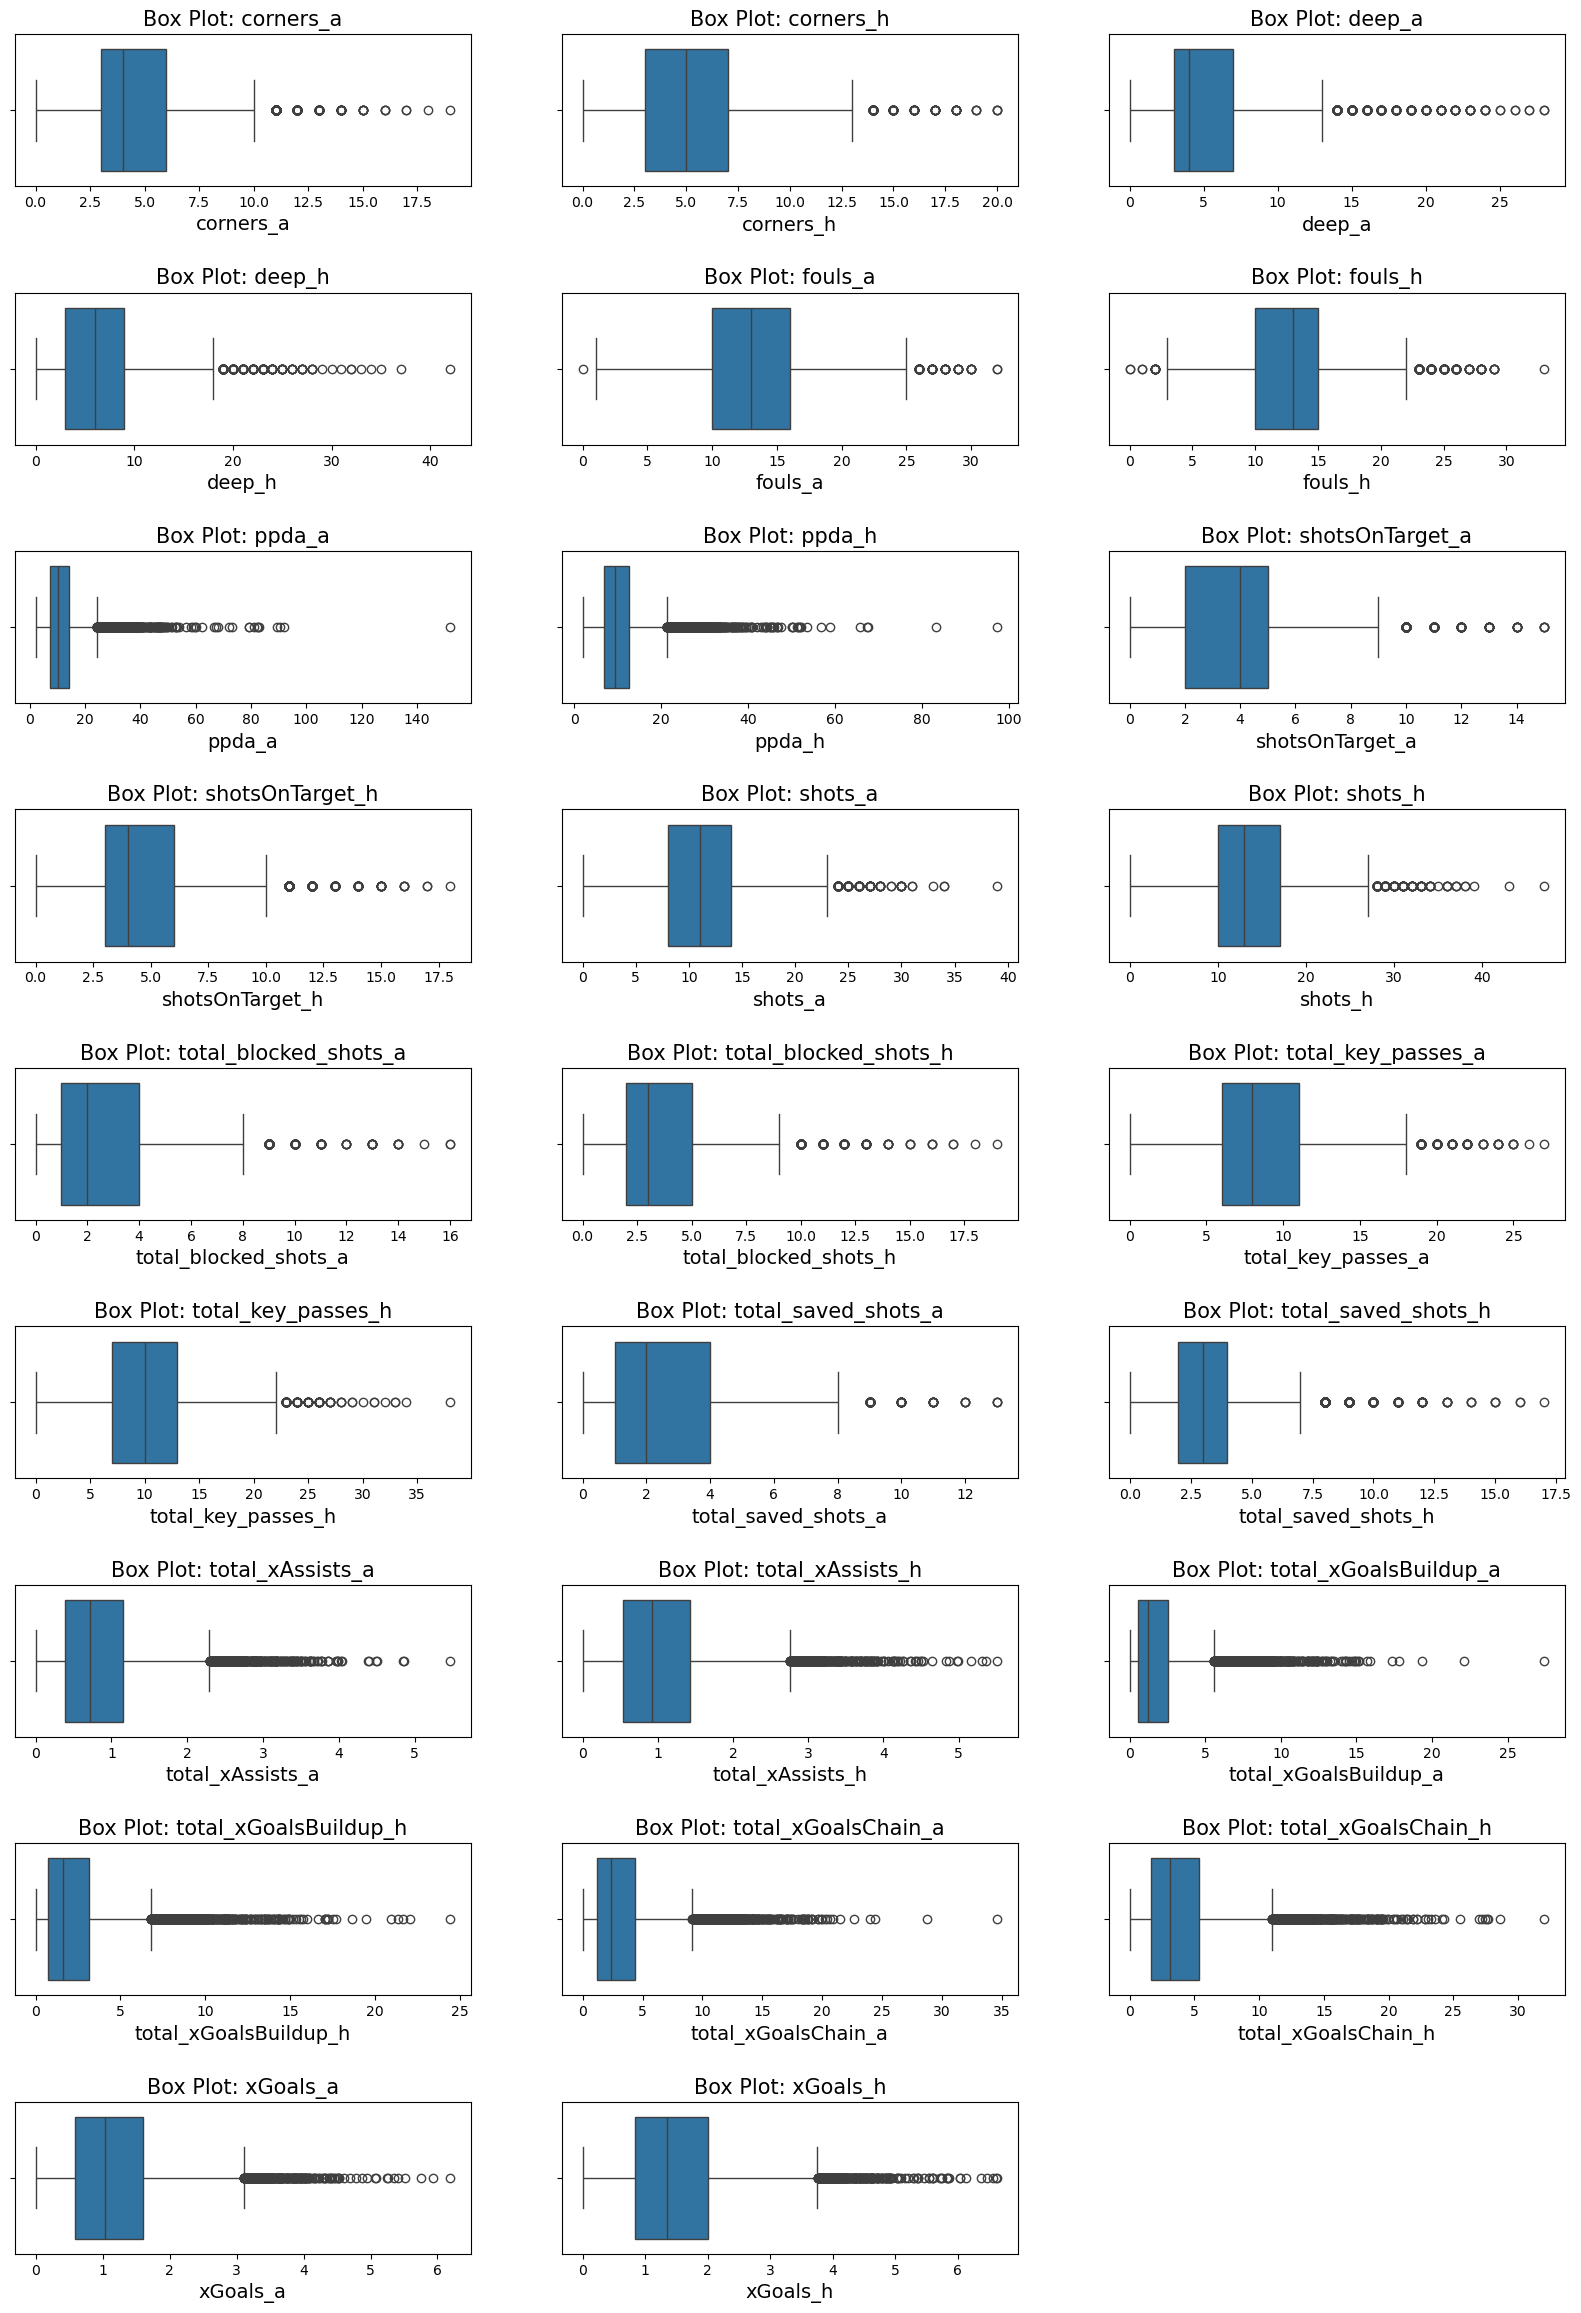

In [110]:
outliers
plt.show()

In [111]:
import pandas as pd
import numpy as np

def outliers_df(df):
    """
    Detects outliers in a numerical dataset using the IQR method.
    
    Returns:
    - A DataFrame with the count and percentage of outliers for each feature.
    """
    total_outliers = pd.DataFrame(columns=['Outlier count', 'Percent'])

    for col in df:
        if col != 'result_h':  # Exclude categorical target column
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            upper_limit = Q3 + 1.5 * IQR
            lower_limit = Q1 - 1.5 * IQR  # Corrected formula

            # Detect outliers
            outliers = df[(df[col] > upper_limit) | (df[col] < lower_limit)]
            num_outliers = len(outliers)

            # Store results
            total_outliers.loc[col] = [num_outliers, (num_outliers / len(df)) * 100]

    return total_outliers[total_outliers['Percent'] > 0].sort_values('Percent', ascending=False)



# Run the function
outliers_df = outliers_df(df_numeric)





In [112]:
outliers_df

,Outlier count,Percent
total_xGoalsBuildup_a,718.0,5.662461
total_xGoalsBuildup_h,664.0,5.236593
ppda_a,606.0,4.779180
ppda_h,540.0,4.258675
total_xGoalsChain_a,538.0,4.242902
total_saved_shots_h,532.0,4.195584
total_xGoalsChain_h,523.0,4.124606
deep_a,423.0,3.335962
total_xAssists_a,389.0,3.067823
shotsOnTarget_h,351.0,2.768139


In [113]:
outliers_result.to_csv(path_result+'/'+'outliers_df.csv')

### new_outliers_df

#### Labeling every outlier with 'Outlier' in order to seperate the outliers from nulls (temporarily, and then to 0/1):

In [114]:
import numpy as np  # Import numpy for numerical operations

def outliers(df,outliers_df):  
    """
    Identifies outliers in a DataFrame and labels them as 'Outlier'.
    Outliers are determined using the interquartile range (IQR) method.
    """
    
    label_out_df = df.copy()  # Create a copy of the input DataFrame to avoid modifying the original data
    
    for col in label_out_df:  # Iterate over each column in the DataFrame
        if col in outliers_result.index:  # Check if the column is listed in 'outliers_df' (this variable needs to be defined elsewhere)
            
            Q1 = label_out_df[col].quantile(0.25)  # Calculate the first quartile (25th percentile)
            Q3 = label_out_df[col].quantile(0.75)  # Calculate the third quartile (75th percentile)
            
            # Compute the upper and lower limits for detecting outliers
            upper_limit = Q1 + 1.5 * (Q3 - Q1)  # Upper limit for detecting outliers
            lower_limit = Q3 - 1.5 * (Q3 - Q1)  # Lower limit for detecting outliers (should be Q1 - 1.5*(Q3-Q1), seems to be a mistake)
            
            # Replace values greater than the upper limit or less than the lower limit with the label 'Outlier'
            label_out_df[col] = np.where(label_out_df[col] > upper_limit, 'Outlier', 
                                         np.where(label_out_df[col] < lower_limit, 'Outlier', label_out_df[col]))
    
    return label_out_df  # Return the modified DataFrame with outliers labeled

# Apply the function to the DataFrame and display the first 10 rows
new_df_outliers = outliers(df,outliers_df)
new_df_outliers.head(10)

,gameID,leagueID,season,date,homeTeamID,awayTeamID,homeGoals,awayGoals,homeGoalsHalfTime,awayGoalsHalfTime,xGoals_h,shots_h,shotsOnTarget_h,deep_h,ppda_h,fouls_h,corners_h,yellowCards_h,redCards_h,teamgoals_h,ownGoals_h,total_assists_h,total_xAssists_h,total_key_passes_h,total_xGoalsChain_h,total_xGoalsBuildup_h,total_blocked_shots_h,total_saved_shots_h,xGoals_a,shots_a,shotsOnTarget_a,deep_a,ppda_a,fouls_a,corners_a,yellowCards_a,redCards_a,teamgoals_a,ownGoals_a,total_assists_a,total_xAssists_a,total_key_passes_a,total_xGoalsChain_a,total_xGoalsBuildup_a,total_blocked_shots_a,total_saved_shots_a,result_h,game_year,game_month,game_day
0,81,1,2015,8/8/2015 15:45,89,82,1,0,1,0,0.627539,9,Outlier,4,13.8261,12,1,2.0,0,0,0,0,0.284978755,5,1.396327948,0.994159963,4.0,1.0,0.6746,9,4,Outlier,8.2188,12,2,3,0,0,1,0,0.586365381,7,1.745370941,0.811548838,3.0,4.0,W,2015,8,8
1,82,1,2015,8/8/2015 18:00,73,71,0,1,0,0,0.876106,11,2,11,6.9,13,6,3.0,0,0,0,0,0.419974941,9,2.159510154,1.170894107,2.0,2.0,0.782253,7,3,2,11.8462,13,3,4,0,1,0,1,0.560695121,4,1.238204654,0.736814573,2.0,2.0,L,2015,8,8
2,83,1,2015,8/8/2015 18:00,72,90,2,2,0,1,0.604226,10,5,5,6.65,Outlier,8,1.0,0,2,0,2,0.549139082,8,1.025550174,0.493522111,2.0,3.0,0.557892,11,5,4,17.1579,13,2,2,0,2,0,1,0.418384951,8,1.959322896,1.030588262,3.0,3.0,D,2015,8,8
3,84,1,2015,8/8/2015 18:00,75,77,4,2,3,0,2.56803,19,Outlier,5,10.88,13,6,2.0,0,4,0,2,1.727543138,Outlier,6.81564863,3.741915636,4.0,4.0,1.45946,11,5,6,9.5556,17,3,4,0,2,0,2,1.288885736,9,Outlier,Outlier,2.0,3.0,W,2015,8,8
4,85,1,2015,8/8/2015 18:00,79,78,1,3,0,1,1.13076,17,6,5,5.7368,14,1,1.0,0,1,0,1,0.416637903,12,1.966623448,0.699248928,3.0,4.0,Outlier,11,Outlier,Outlier,10.625,Outlier,4,0,0,3,0,3,Outlier,10,Outlier,Outlier,2.0,4.0,L,2015,8,8
5,86,1,2015,8/8/2015 20:30,80,84,2,2,2,1,0.64396,11,3,10,10.3636,15,4,1.0,1,1,0,0,0.42361562,8,1.719828486,0.961012319,3.0,2.0,Outlier,17,Outlier,5,8.8333,16,Outlier,3,0,2,1,0,1.186018845,12,5.703604672,2.818096895,Outlier,Outlier,D,2015,8,8
6,87,1,2015,8/9/2015 16:30,86,74,2,2,1,1,1.54613,9,4,3,12.7222,9,6,2.0,0,2,0,1,0.570525074,8,1.078108296,0.439387508,3.0,1.0,1.2529,14,4,5,7.0,12,6,4,0,2,0,2,1.136786842,12,2.669754811,1.736369898,3.0,2.0,D,2015,8,9
7,88,1,2015,8/9/2015 16:30,83,81,0,2,0,1,1.33166,Outlier,6,11,8.1667,12,5,1.0,0,0,0,0,1.112352483,Outlier,4.820514023,2.779104684,Outlier,Outlier,0.535961,8,4,Outlier,12.4545,9,4,3,0,2,0,1,0.514490917,7,0.66350198,0.39296926,2.0,2.0,L,2015,8,9
8,89,1,2015,8/9/2015 19:00,85,87,0,1,0,0,0.381274,7,Outlier,2,11.913,9,3,2.0,0,0,0,0,0.136028878,4,1.234306,0.798492454,2.0,1.0,0.329873,8,3,5,9.3462,16,5,4,0,1,0,1,0.278120922,5,0.437690532,0.082702087,4.0,2.0,L,2015,8,9
9,90,1,2015,8/10/2015 23:00,76,88,0,3,0,2,0.435238,9,2,4,Outlier,12,6,4.0,0,0,0,0,0.334356616,6,0.963304125,0.60436199,1.0,2.0,1.9242,Outlier,Outlier,8,8.087,9,6,1,0,3,0,3,1.241608147,Outlier,5.636727333,3.015425406,Outlier,5.0,L,2015,8,10


### df_outliers

#### Creating a dataframe with outliers as 1 and non-outliers as 0:

In [115]:
df_outliers = new_df_outliers.isin(['Outlier']) 
df_outliers = df_outliers.astype('int')
df_outliers

,gameID,leagueID,season,date,homeTeamID,awayTeamID,homeGoals,awayGoals,homeGoalsHalfTime,awayGoalsHalfTime,xGoals_h,shots_h,shotsOnTarget_h,deep_h,ppda_h,fouls_h,corners_h,yellowCards_h,redCards_h,teamgoals_h,ownGoals_h,total_assists_h,total_xAssists_h,total_key_passes_h,total_xGoalsChain_h,total_xGoalsBuildup_h,total_blocked_shots_h,total_saved_shots_h,xGoals_a,shots_a,shotsOnTarget_a,deep_a,ppda_a,fouls_a,corners_a,yellowCards_a,redCards_a,teamgoals_a,ownGoals_a,total_assists_a,total_xAssists_a,total_key_passes_a,total_xGoalsChain_a,total_xGoalsBuildup_a,total_blocked_shots_a,total_saved_shots_a,result_h,game_year,game_month,game_day
0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,1,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12675,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12676,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12677,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12678,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Now that we have a dataframe saving all the outliers we'll convert all the outliers to nulls, just so I can see differences in distribution with and without outliers and then decide which of the outliers to remove or not:

In [116]:
def capping(df,outliers_df):
    temp = df.copy()
    for col in temp:
        if col in outliers_result.index:
            Q1 = temp[col].quantile(0.25)
            Q3 = temp[col].quantile(0.75)
            upper_limit = Q1 + 1.5 * (Q3-Q1)
            lower_limit = Q3 - 1.5 * (Q3-Q1)
            temp[col] = np.where(temp[col] > upper_limit,np.nan,np.where(temp[col] < lower_limit,np.nan,temp[col]))
    return temp
temp = capping(df,outliers_df)
temp

,gameID,leagueID,season,date,homeTeamID,awayTeamID,homeGoals,awayGoals,homeGoalsHalfTime,awayGoalsHalfTime,xGoals_h,shots_h,shotsOnTarget_h,deep_h,ppda_h,fouls_h,corners_h,yellowCards_h,redCards_h,teamgoals_h,ownGoals_h,total_assists_h,total_xAssists_h,total_key_passes_h,total_xGoalsChain_h,total_xGoalsBuildup_h,total_blocked_shots_h,total_saved_shots_h,xGoals_a,shots_a,shotsOnTarget_a,deep_a,ppda_a,fouls_a,corners_a,yellowCards_a,redCards_a,teamgoals_a,ownGoals_a,total_assists_a,total_xAssists_a,total_key_passes_a,total_xGoalsChain_a,total_xGoalsBuildup_a,total_blocked_shots_a,total_saved_shots_a,result_h,game_year,game_month,game_day
0,81,1,2015,8/8/2015 15:45,89,82,1,0,1,0,0.627539,9.0,NaN,4.0,13.8261,12.0,1.0,2.0,0,0,0,0,0.284979,5.0,1.396328,0.994160,4.0,1.0,0.674600,9.0,4.0,NaN,8.2188,12.0,2.0,3,0,0,1,0,0.586365,7.0,1.745371,0.811549,3.0,4.0,W,2015,8,8
1,82,1,2015,8/8/2015 18:00,73,71,0,1,0,0,0.876106,11.0,2.0,11.0,6.9000,13.0,6.0,3.0,0,0,0,0,0.419975,9.0,2.159510,1.170894,2.0,2.0,0.782253,7.0,3.0,2.0,11.8462,13.0,3.0,4,0,1,0,1,0.560695,4.0,1.238205,0.736815,2.0,2.0,L,2015,8,8
2,83,1,2015,8/8/2015 18:00,72,90,2,2,0,1,0.604226,10.0,5.0,5.0,6.6500,NaN,8.0,1.0,0,2,0,2,0.549139,8.0,1.025550,0.493522,2.0,3.0,0.557892,11.0,5.0,4.0,17.1579,13.0,2.0,2,0,2,0,1,0.418385,8.0,1.959323,1.030588,3.0,3.0,D,2015,8,8
3,84,1,2015,8/8/2015 18:00,75,77,4,2,3,0,2.568030,19.0,NaN,5.0,10.8800,13.0,6.0,2.0,0,4,0,2,1.727543,NaN,6.815649,3.741916,4.0,4.0,1.459460,11.0,5.0,6.0,9.5556,17.0,3.0,4,0,2,0,2,1.288886,9.0,NaN,NaN,2.0,3.0,W,2015,8,8
4,85,1,2015,8/8/2015 18:00,79,78,1,3,0,1,1.130760,17.0,6.0,5.0,5.7368,14.0,1.0,1.0,0,1,0,1,0.416638,12.0,1.966623,0.699249,3.0,4.0,NaN,11.0,NaN,NaN,10.6250,NaN,4.0,0,0,3,0,3,NaN,10.0,NaN,NaN,2.0,4.0,L,2015,8,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12675,16131,5,2020,5/23/2021 19:00,168,166,1,2,1,1,1.411190,15.0,5.0,NaN,12.3684,8.0,9.0,2.0,0,1,0,1,0.971853,11.0,3.853730,1.999150,6.0,4.0,1.707510,8.0,5.0,3.0,8.3529,11.0,5.0,2,0,2,0,1,0.307960,4.0,1.223212,0.715843,1.0,3.0,L,2021,5,23
12676,16132,5,2020,5/23/2021 19:00,177,176,1,2,1,1,1.198190,10.0,3.0,3.0,NaN,11.0,5.0,1.0,0,1,0,1,0.855524,8.0,1.962812,1.028432,3.0,2.0,1.238050,12.0,5.0,4.0,NaN,NaN,2.0,1,0,2,0,1,0.775388,7.0,2.610665,1.758012,4.0,3.0,L,2021,5,23
12677,16133,5,2020,5/23/2021 19:00,163,235,2,0,1,0,1.332690,12.0,6.0,10.0,8.2857,11.0,4.0,1.0,0,2,0,1,1.151649,8.0,NaN,NaN,2.0,4.0,0.357583,9.0,2.0,NaN,NaN,10.0,3.0,0,0,0,0,0,0.216965,6.0,0.884652,0.544502,0.0,2.0,W,2021,5,23
12678,16134,5,2020,5/23/2021 19:00,175,181,0,1,0,1,1.460500,19.0,5.0,6.0,7.5600,13.0,9.0,1.0,0,0,0,0,1.265829,13.0,4.790546,3.092978,5.0,5.0,1.380290,10.0,2.0,3.0,14.7200,10.0,3.0,0,0,1,0,1,0.565077,6.0,1.256511,0.764512,1.0,1.0,L,2021,5,23


#### Saving the inter quartal outliers dataframe for future reference.

In [117]:
temp.to_csv(path_result+'/'+'outliers_q_df.csv')


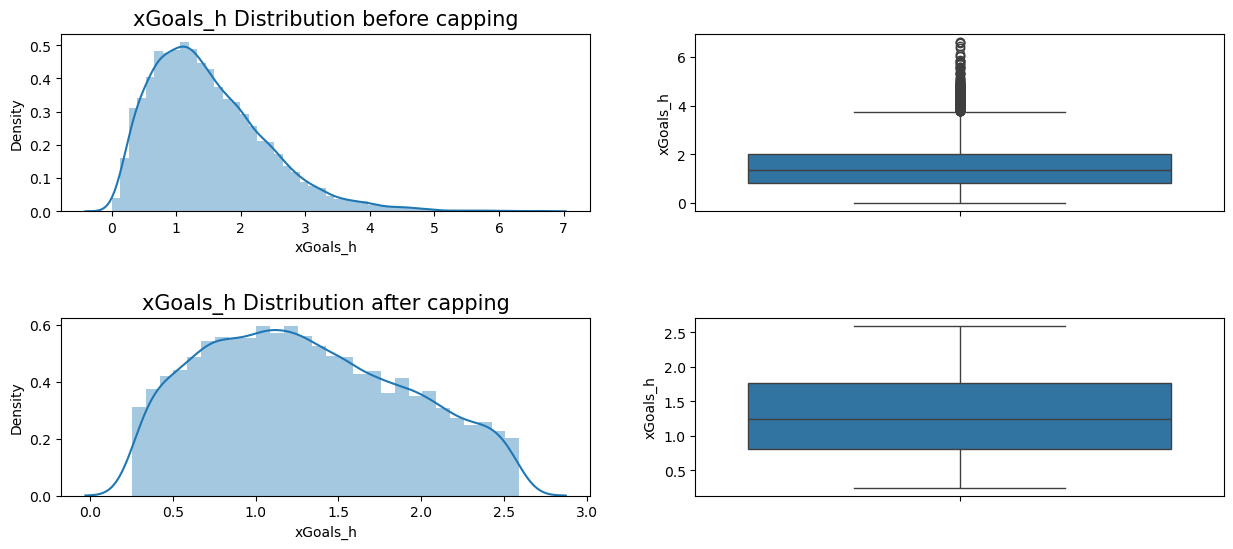

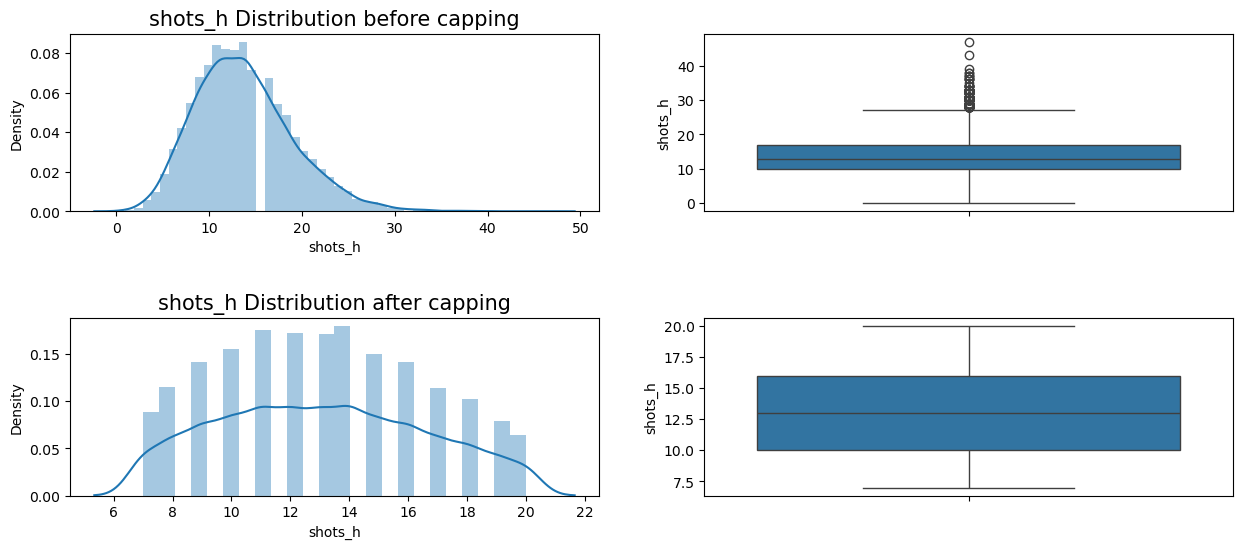

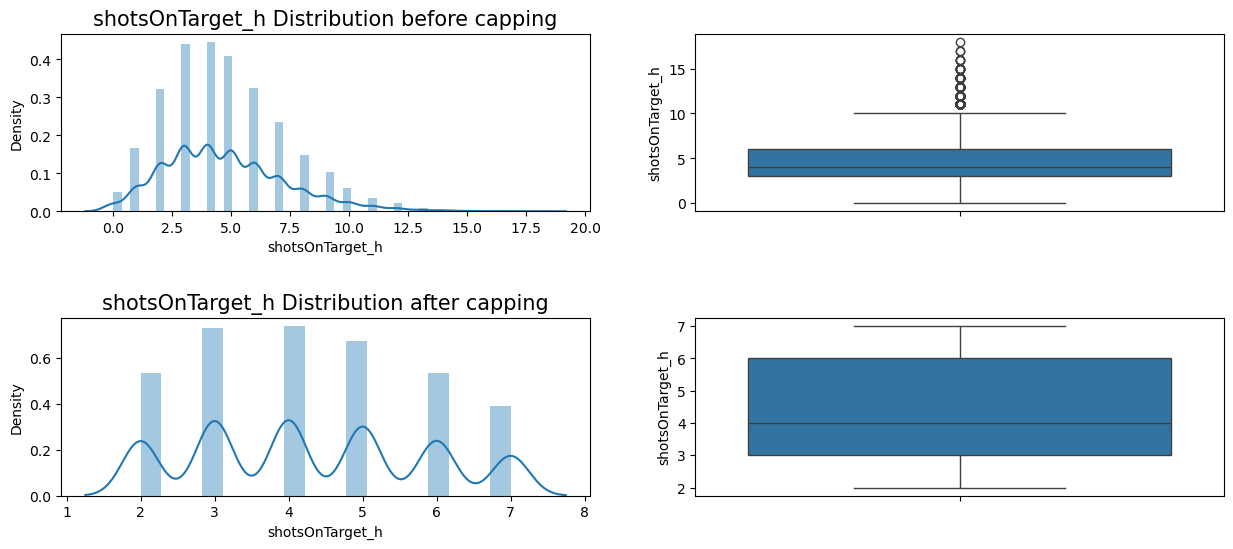

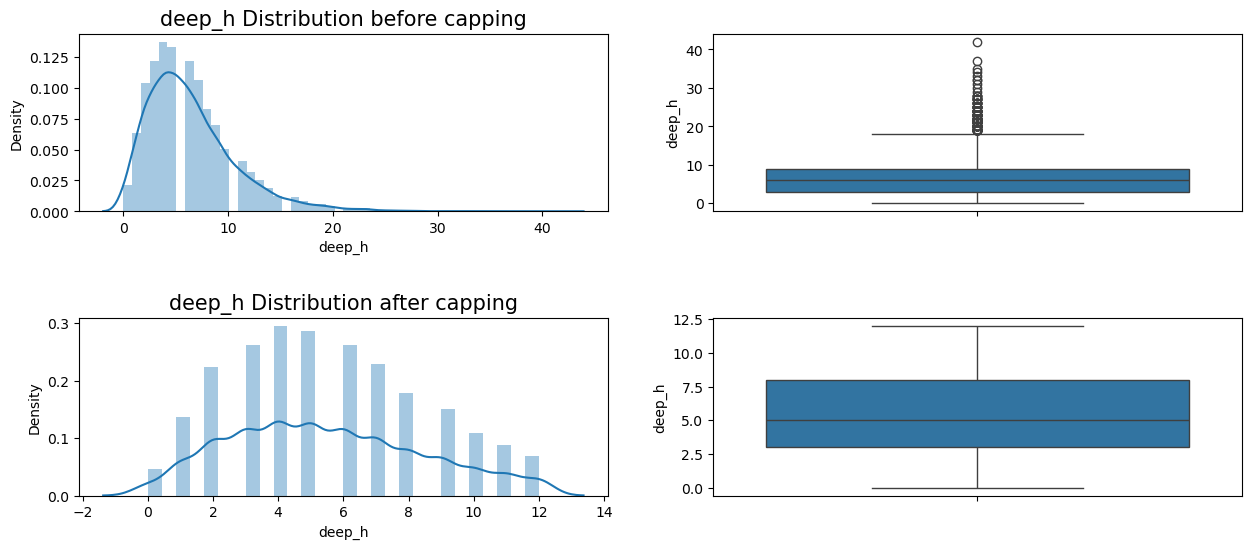

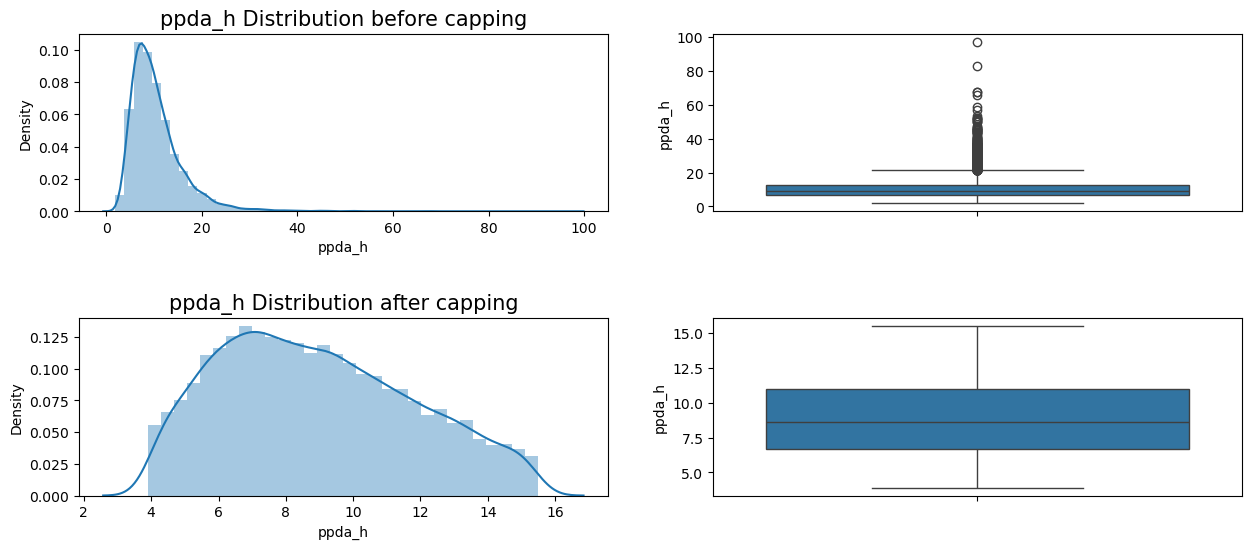

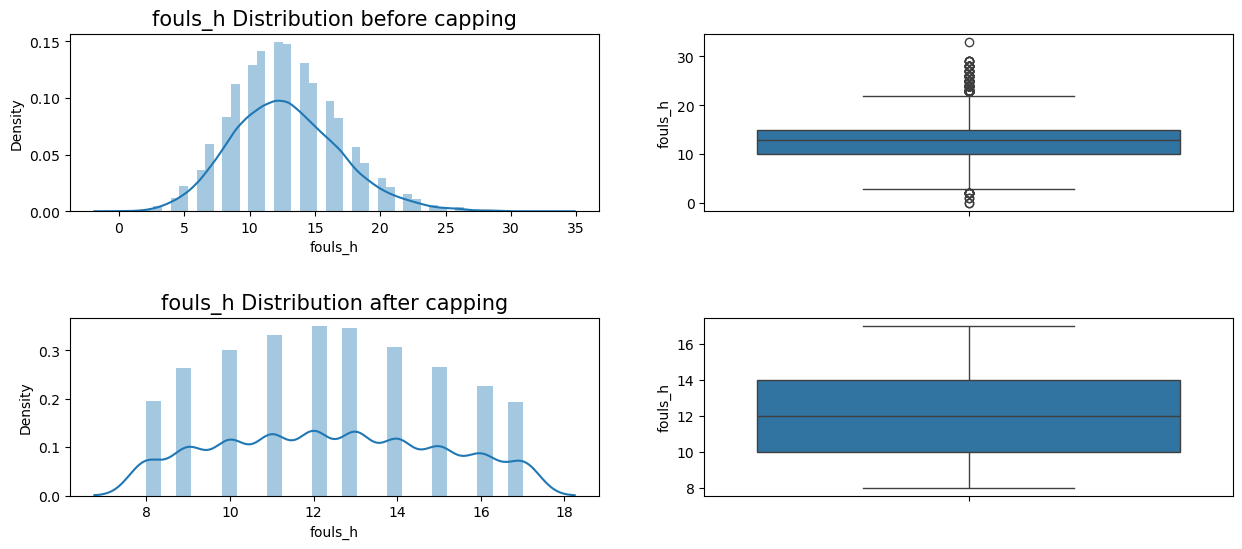

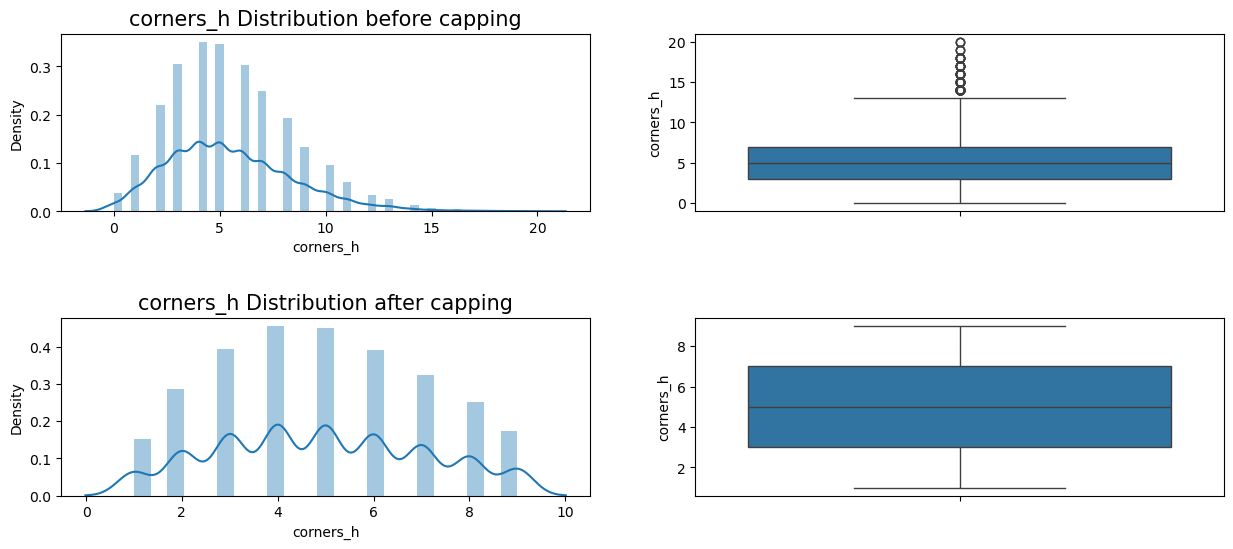

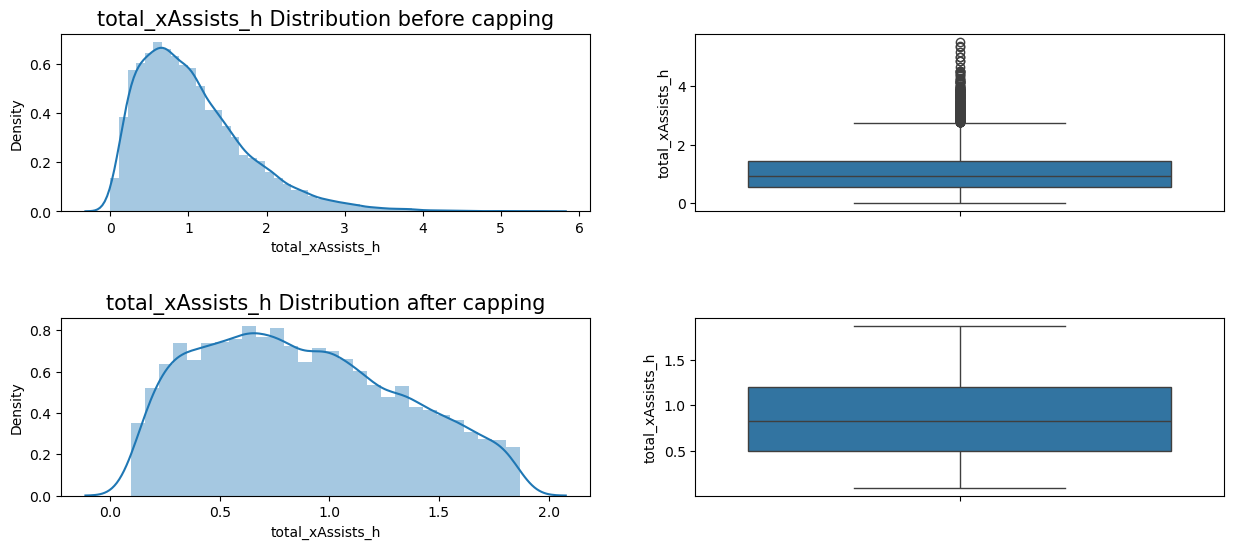

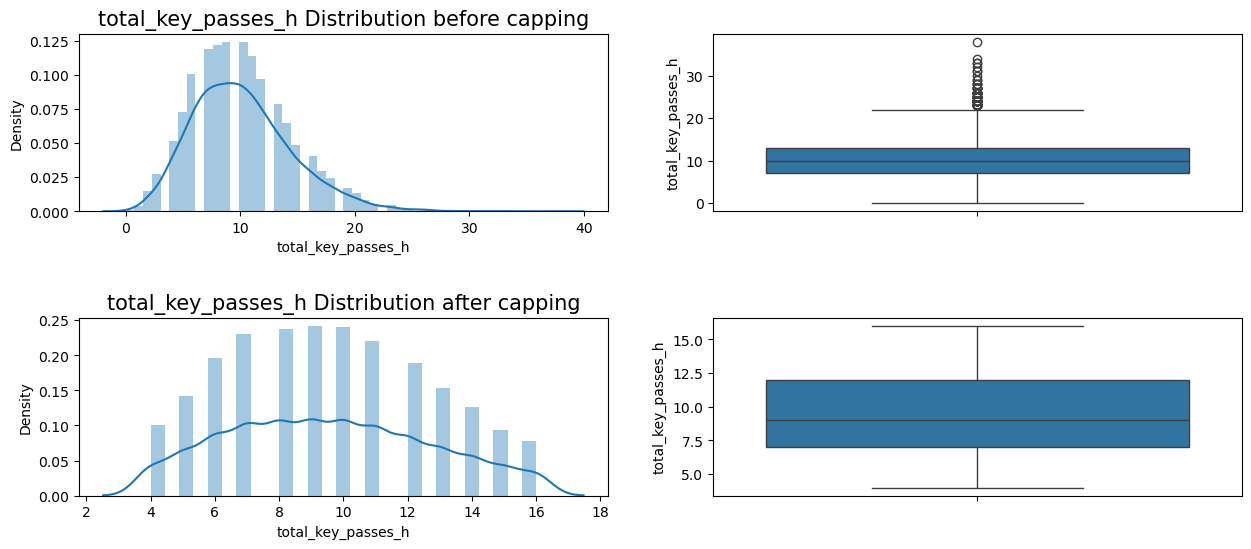

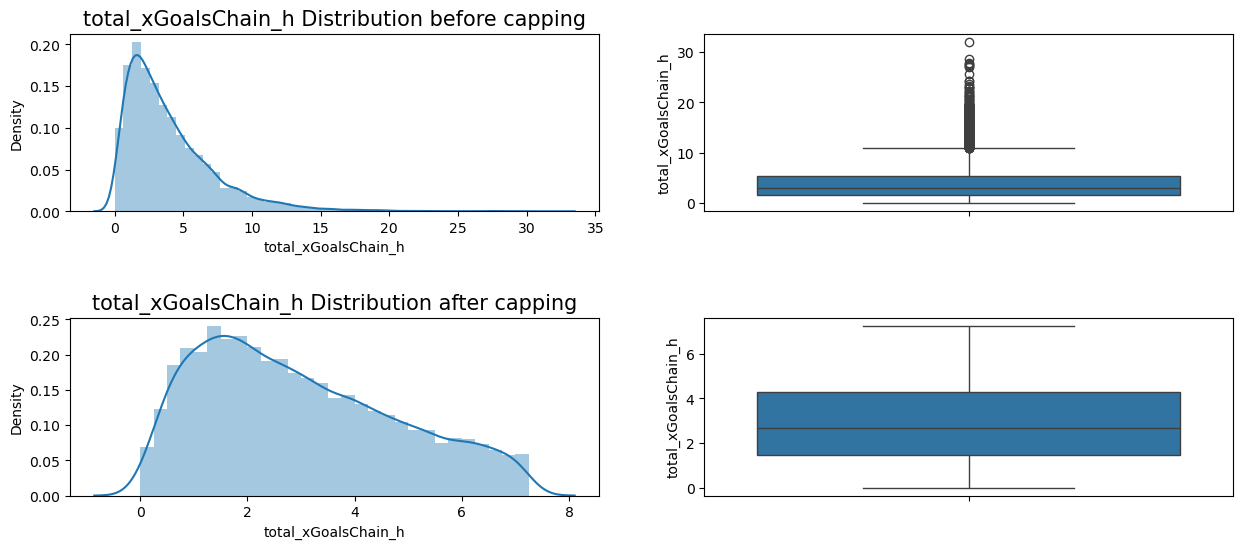

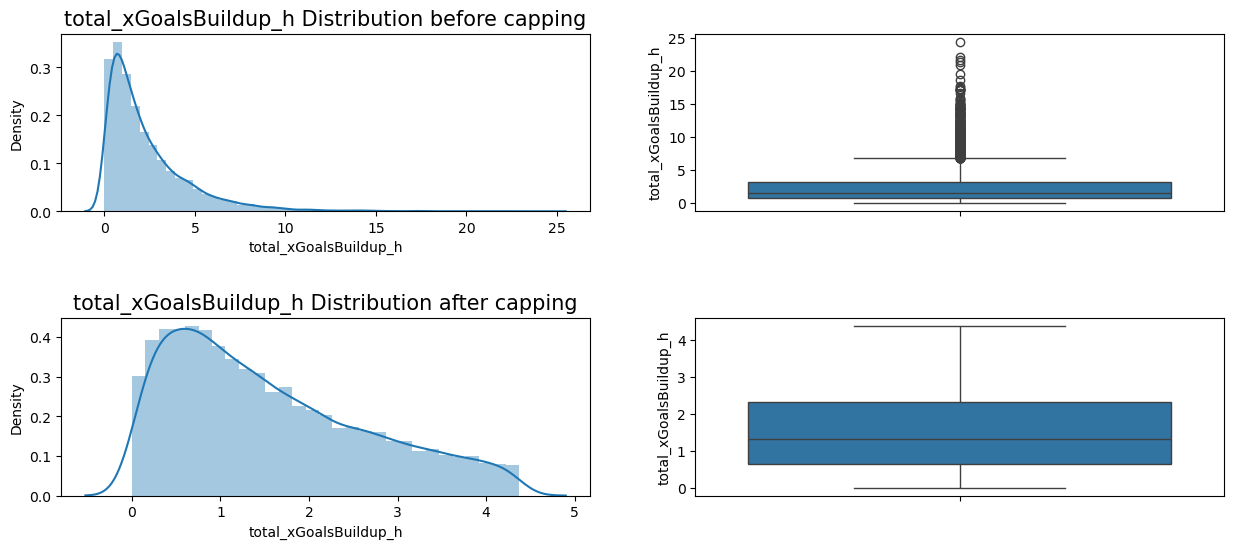

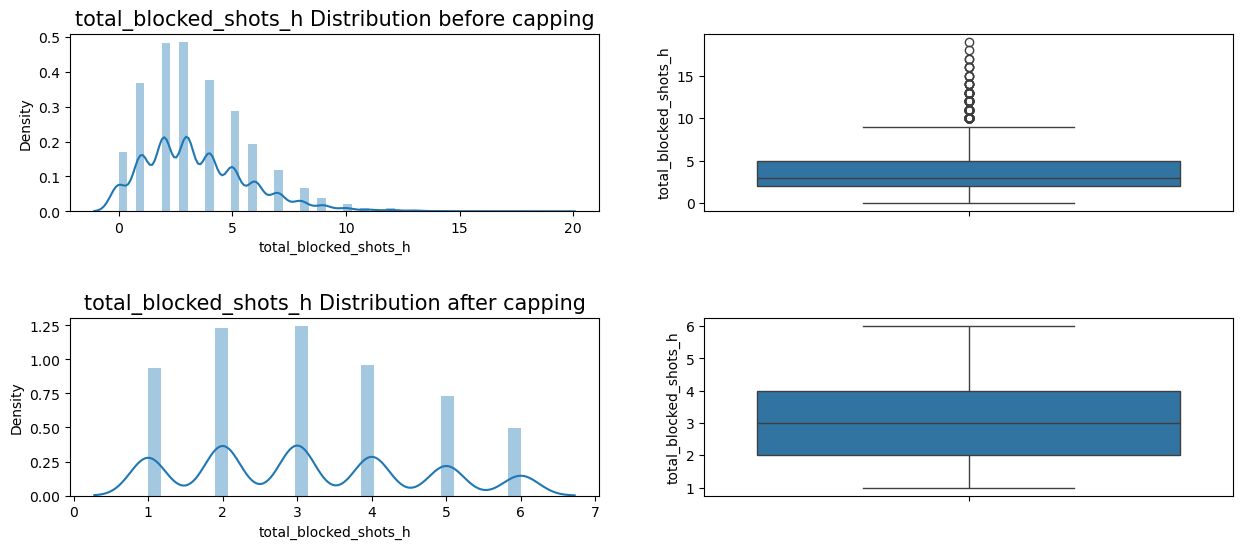

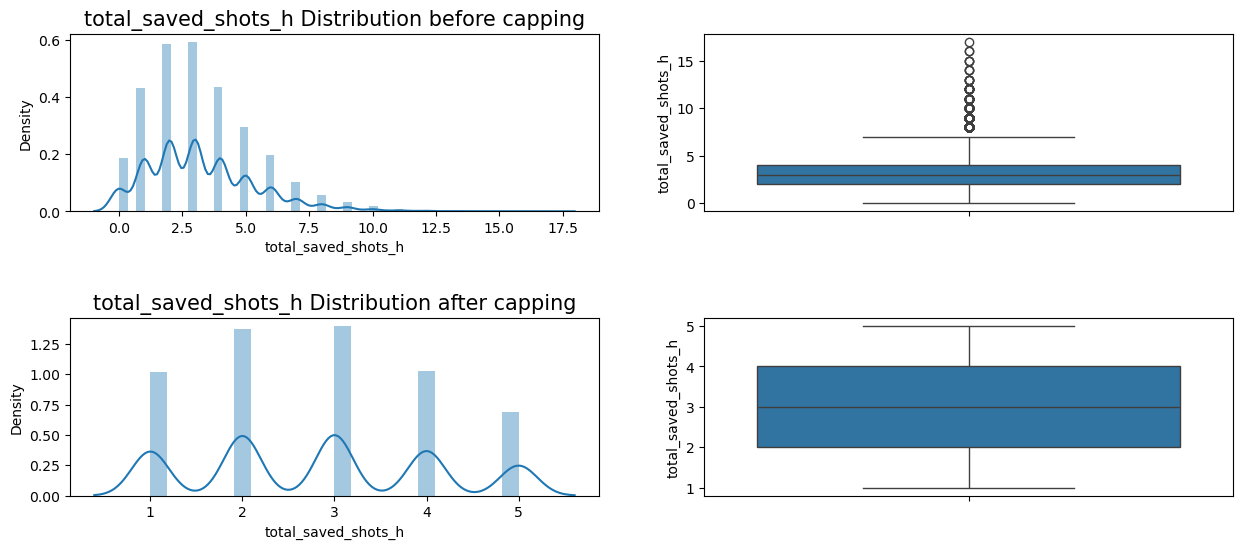

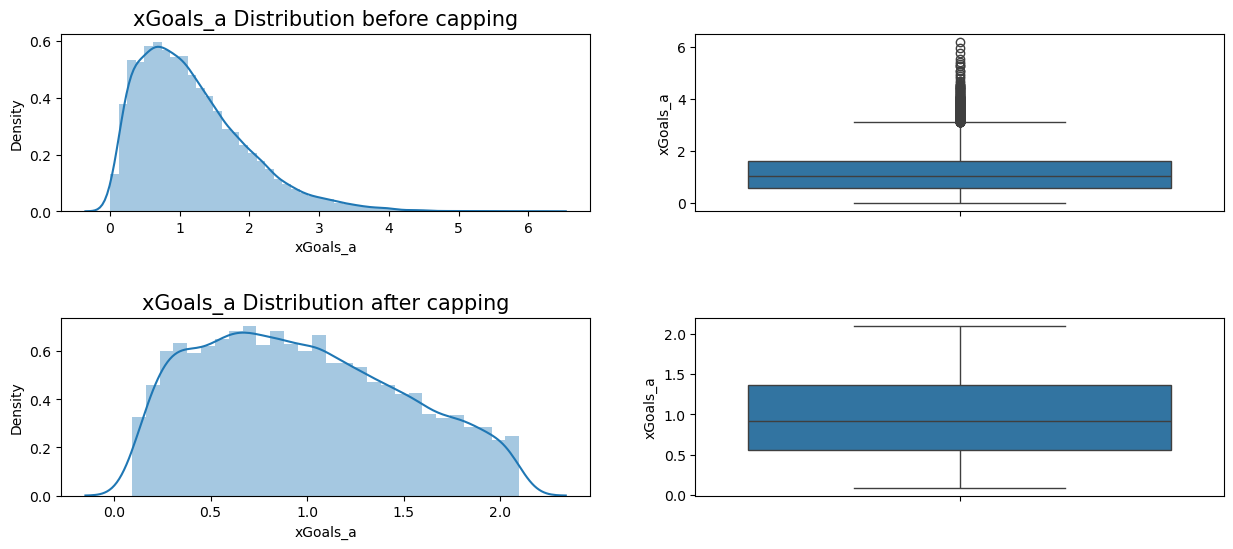

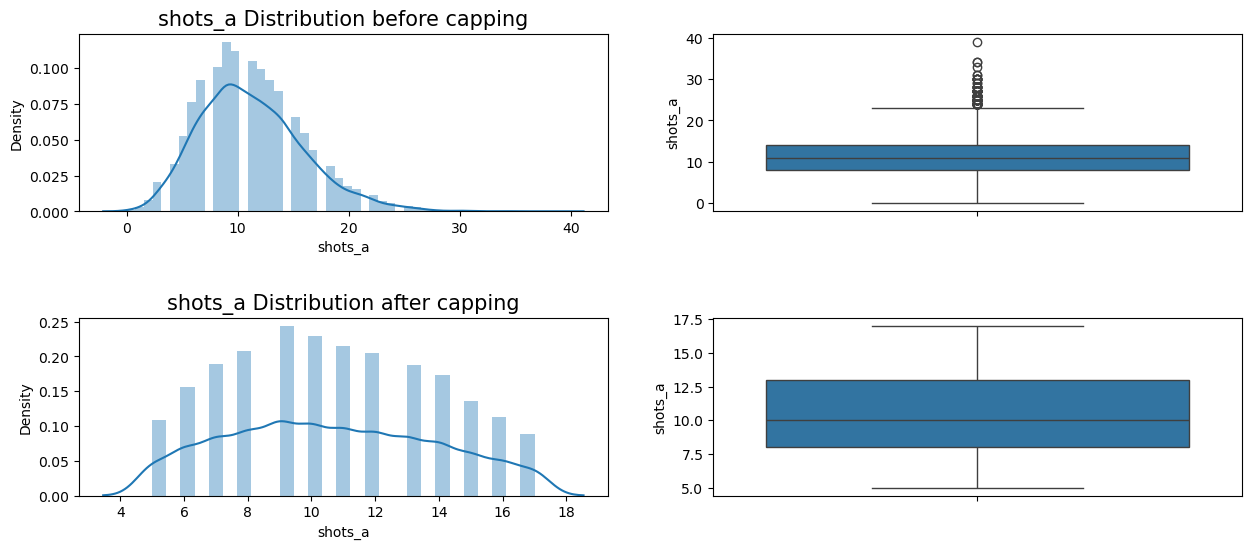

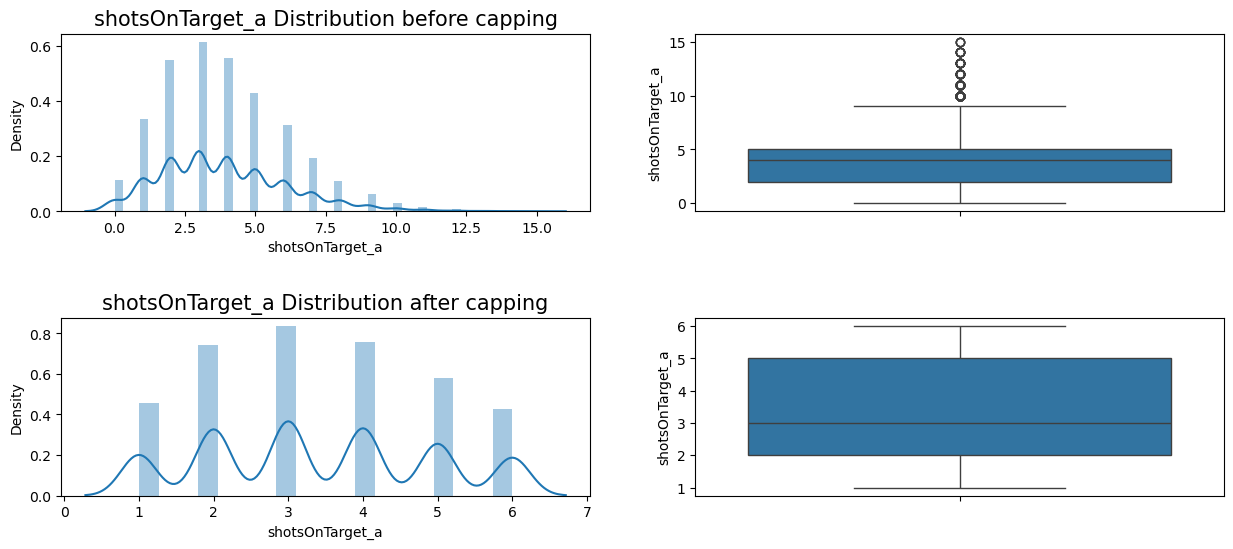

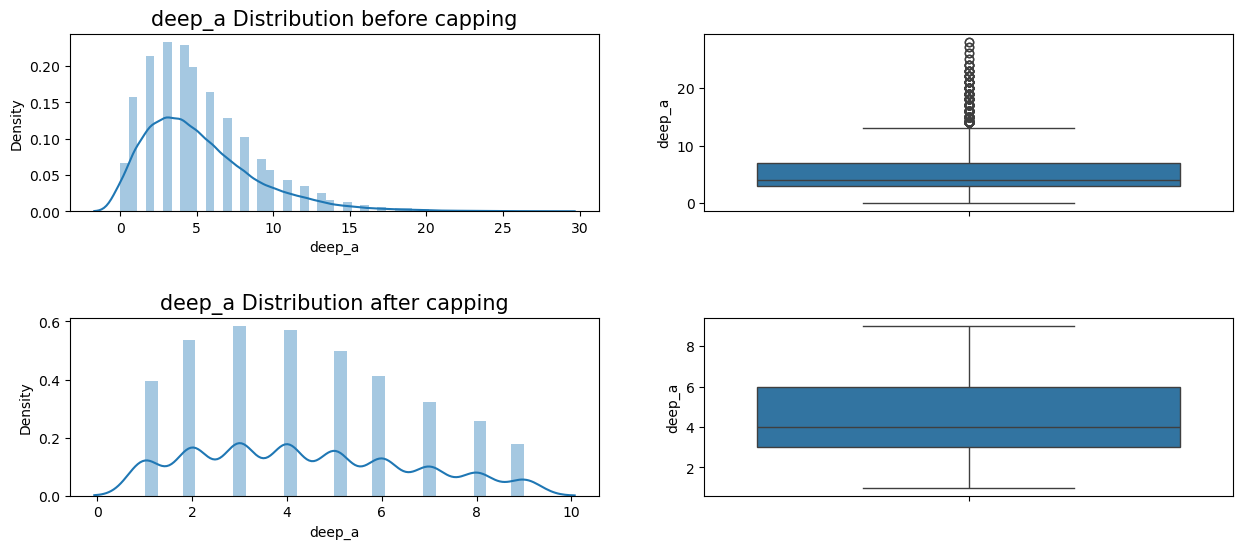

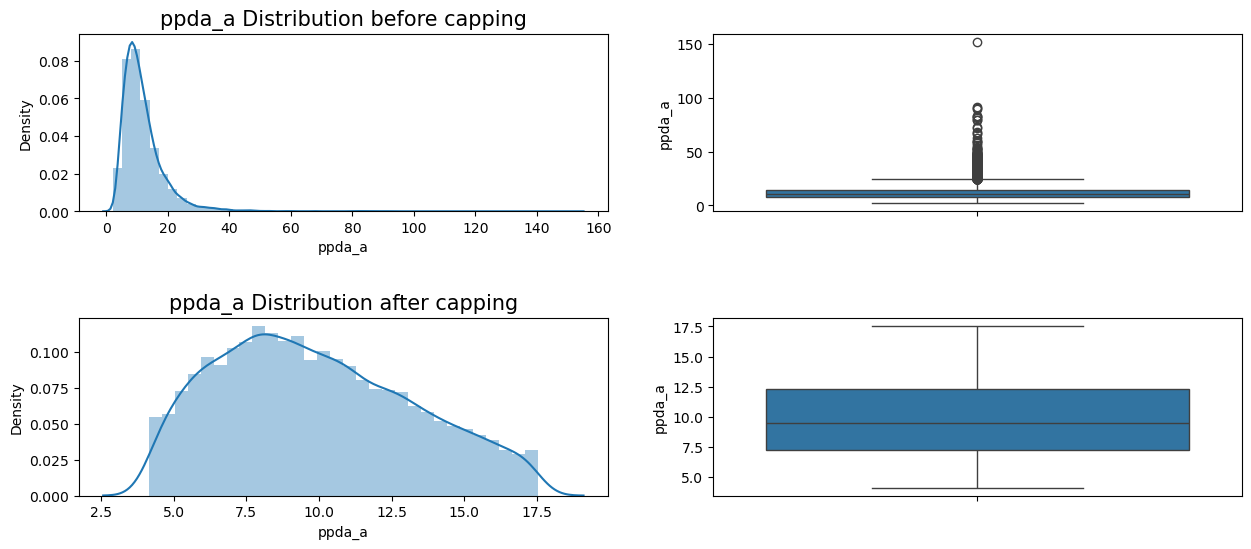

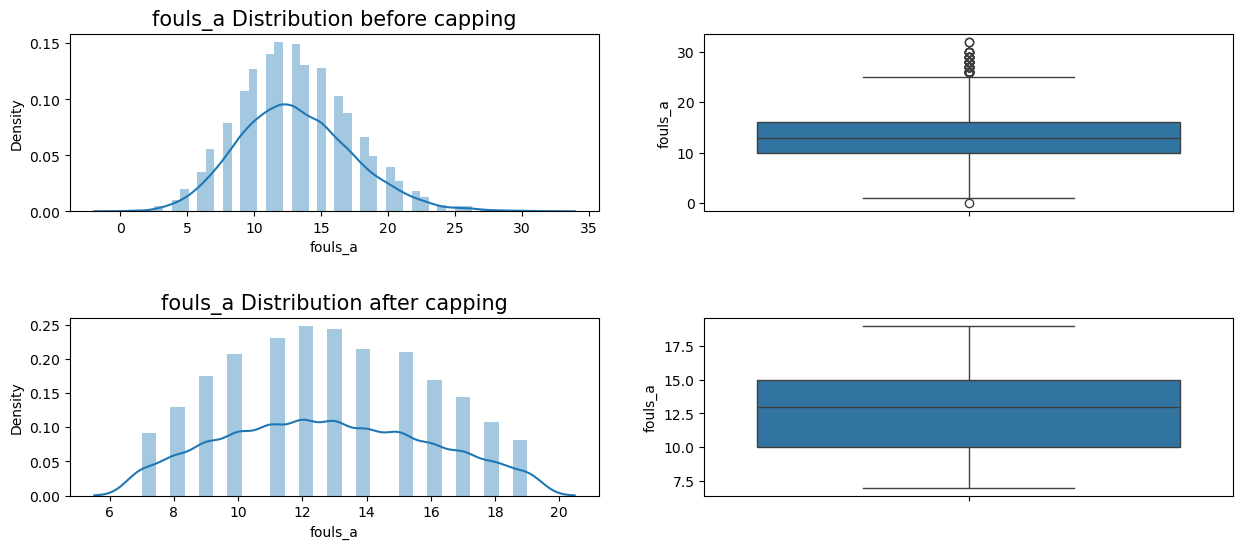

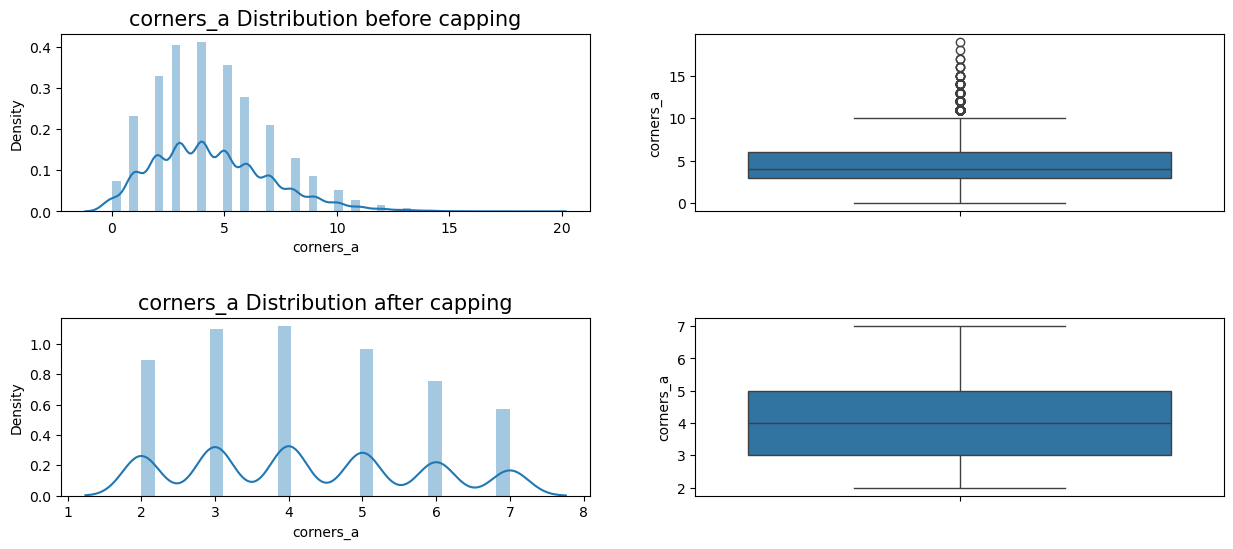

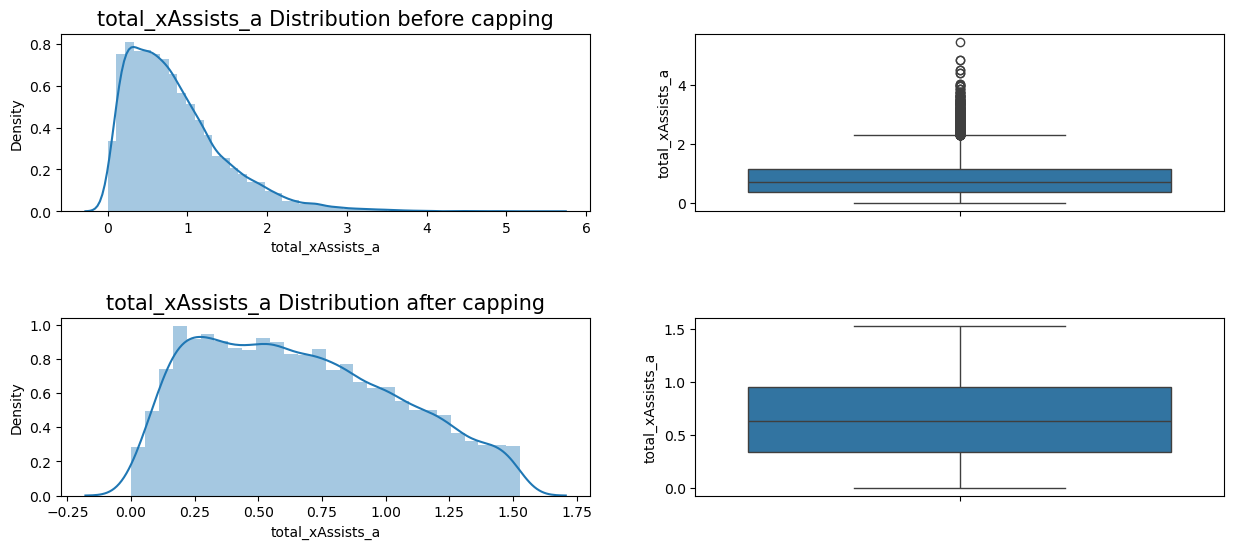

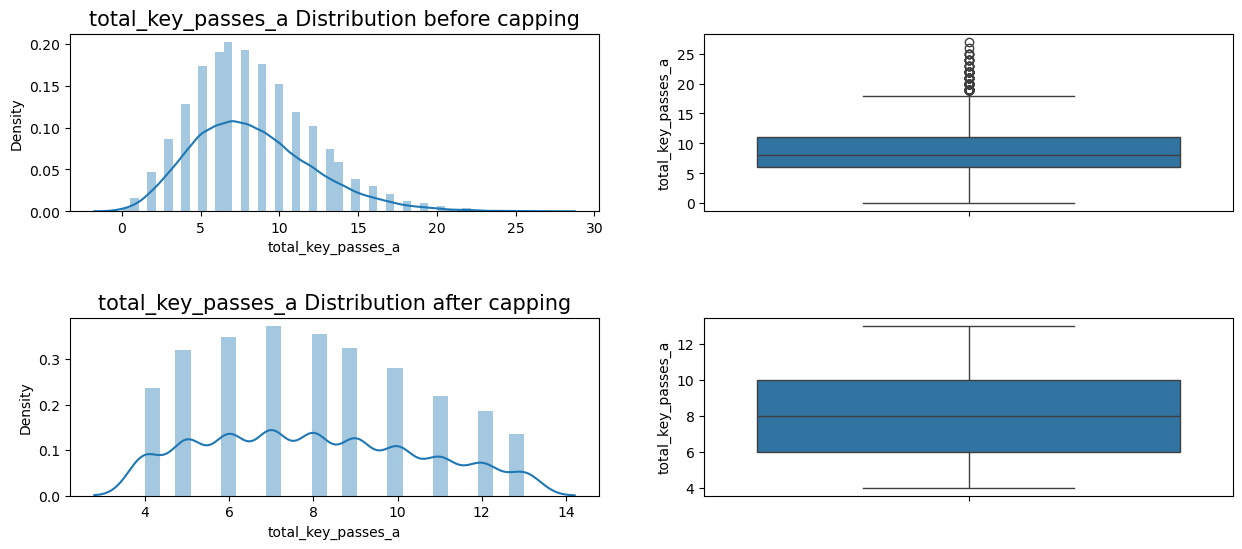

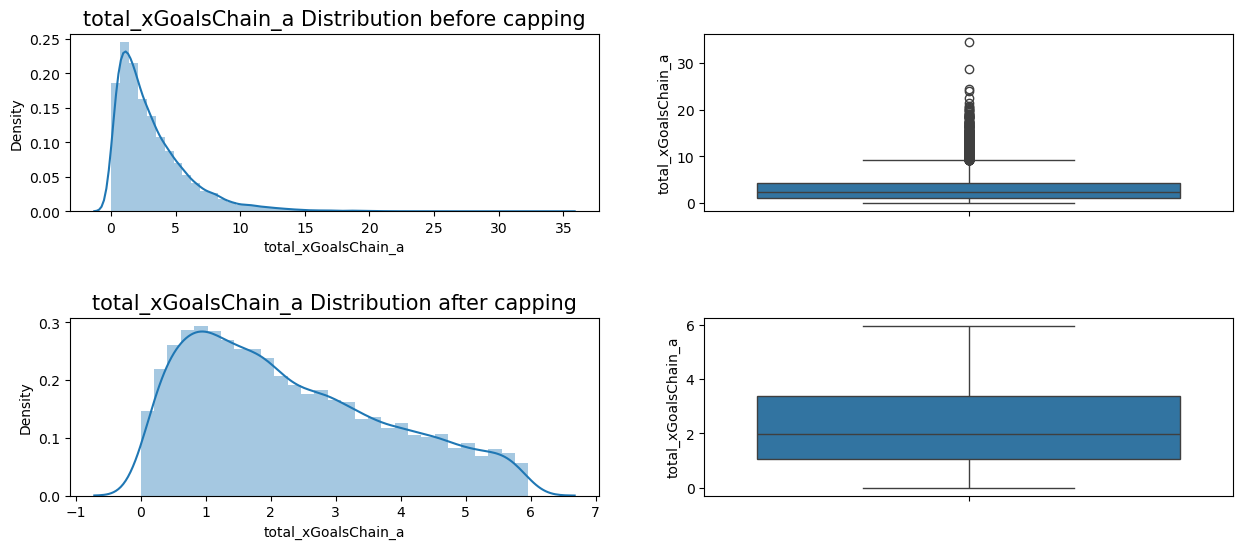

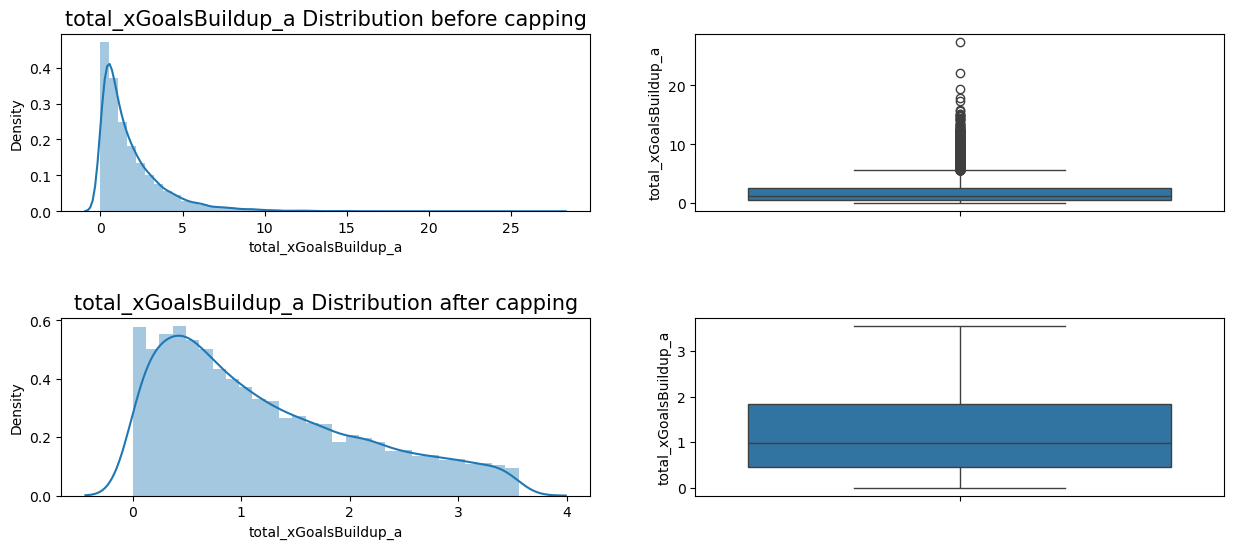

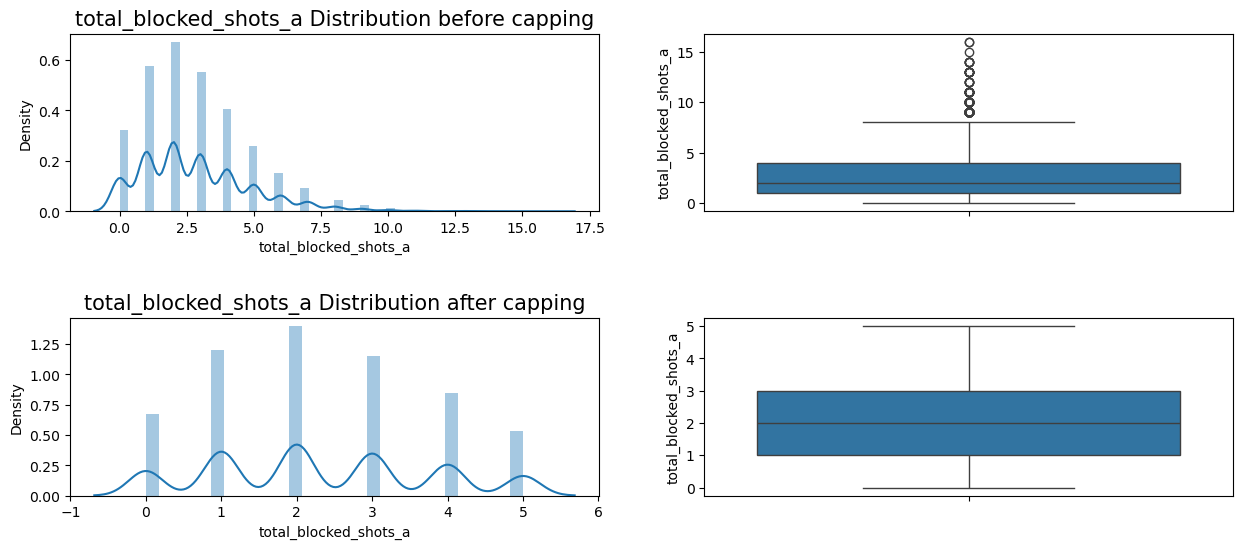

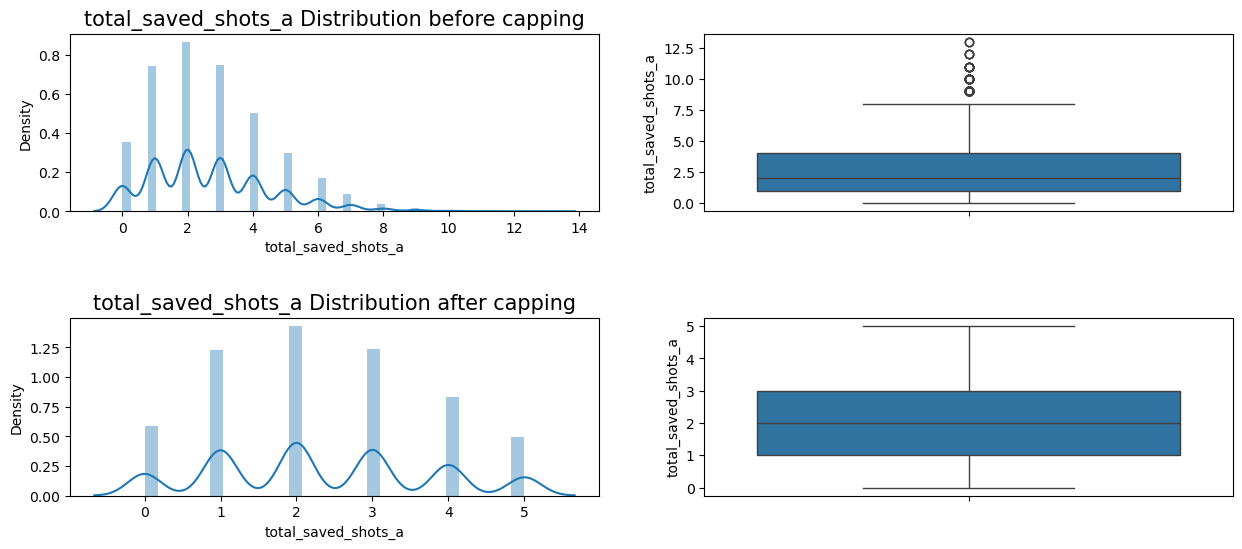

In [118]:
def dist_outliers(original_df, new, cols):
    for col in original_df:
        if col in cols:
            plt.figure(figsize=(15,6))
            plt.subplot(2,2,1)
            sns.distplot(original_df[col])
            plt.title('{} Distribution before capping'.format(col), fontsize=15)
            plt.subplot(2,2,2)
            sns.boxplot(original_df[col])
            plt.subplots_adjust(hspace = 0.6)
            plt.subplot(2,2,3)
            sns.distplot(new[col])
            plt.title('{} Distribution after capping'.format(col), fontsize=15)
            plt.subplot(2,2,4)
            sns.boxplot(new[col])
            plt.show()
dist_outliers(df, temp, outliers_df.index)

##### We clearly need to filter some features that either the feature distribution has changed significantly, or cases where removing outliers results with only one value.

Checking if distribution (Kolmogorov–Smirnov) and/or correlation has changed significantly:

In [119]:
### differences between two correlation in Python: https://github.com/psinger/CorrelationStats
### We will only take from the code the Fisher method for two-tailed test
def cocor(x1,y1, x2,y2):
    xy1 = x1.corr(y1, method='spearman')
    xy2 = x2.corr(y2, method='spearman')
    n1 = len(x1)
    n2 = len(x2)
    xy_z = 0.5 * np.log((1 + xy1)/(1 - xy1))
    ab_z = 0.5 * np.log((1 + xy2)/(1 - xy2))
    if n2 is None:
        n2 = n1
    se_diff_r = np.sqrt(1/(n1 - 3) + 1/(n2 - 3))
    diff = xy_z - ab_z
    z = abs(diff / se_diff_r)
    p = (1 - norm.cdf(z)) * 2
    return z, p

In [121]:
# change result_h to category
df['result'] = df['result_h'].map({'W': 2, 'D': 1, 'L': 0})

In [122]:
import numpy as np
import pandas as pd
from scipy.stats import ks_2samp

def analyze_outlier_impact(df, df_numeric, df_outliers, target_col, cocor_func):
    """
    Analyze how removing outliers affects feature distribution and correlation with a target variable.

    Parameters:
    - df: Full DataFrame including the target column
    - df_numeric: Numeric columns from df
    - df_outliers: Same shape as df_numeric, 1 = outlier, 0 = not
    - target_col: Name of the target column in df
    - cocor_func: Function that returns (correlation_diff, p_value) when comparing two correlations

    Returns:
    - out_df: DataFrame summarizing outlier impact for each feature
    """
    out_df = pd.DataFrame(columns=['feature', 'outliers_cnt', 'distribution_changed', 'correlation_changed'])

    np.seterr(divide='ignore', invalid='ignore')  # suppress warnings

    for col in df_numeric.columns:
        if col == target_col or col not in df_outliers.columns:
            continue

        # Full feature and label
        out = df_numeric[col]
        result_out = df[target_col]

        # Feature and label with outliers removed
        non = df_numeric[col].loc[df_outliers[col] == 0]
        result_non = df[target_col].loc[df_outliers[col] == 0]

        # Correlation change
        _, p_corr = cocor_func(out, result_out, non, result_non)
        cor_change = '+' if p_corr < 0.05 else '-'

        # Distribution change
        p_ks = ks_2samp(out, non)[1]
        dist_change = '+' if p_ks < 0.05 else '-'

        # Count of outliers
        mv = df_outliers[col].sum()

        # Append to summary
        out_df = pd.concat([out_df, pd.DataFrame([{
            'feature': col,
            'outliers_cnt': mv,
            'distribution_changed': dist_change,
            'correlation_changed': cor_change
        }])], ignore_index=True)

    return out_df


In [123]:
out_df = analyze_outlier_impact(
    df=df,
    df_numeric=df_numeric,
    df_outliers=df_outliers,
    target_col='result',
    cocor_func=cocor
)

In [124]:
out_df

,feature,outliers_cnt,distribution_changed,correlation_changed
0,corners_a,3062,+,-
1,corners_h,1428,+,-
2,deep_a,2031,+,+
3,deep_h,1108,+,+
4,fouls_a,1533,+,-
5,fouls_h,2749,+,-
6,ppda_a,2070,+,+
7,ppda_h,2063,+,+
8,shotsOnTarget_a,2057,+,+
9,shotsOnTarget_h,2759,+,+


In [ ]:
we will drop the columns that bowth the correlation and distribution didnt 

In [126]:
#All 'Yes' Vars in the 'Drop'colums shall be deleted, since the infect correlation and distribution. 
#We don't want to delete vars that will change the distribution
out_df['drop']='yes'
out_df.loc[(out_df.distribution_changed=='+')& (out_df.correlation_changed=='+'),'drop'] = 'no'
out_df

,feature,outliers_cnt,distribution_changed,correlation_changed,drop
0,corners_a,3062,+,-,yes
1,corners_h,1428,+,-,yes
2,deep_a,2031,+,+,no
3,deep_h,1108,+,+,no
4,fouls_a,1533,+,-,yes
5,fouls_h,2749,+,-,yes
6,ppda_a,2070,+,+,no
7,ppda_h,2063,+,+,no
8,shotsOnTarget_a,2057,+,+,no
9,shotsOnTarget_h,2759,+,+,no


In [127]:
relevant_columns=out_df.loc[out_df['drop']=='yes']
relevant_columns

,feature,outliers_cnt,distribution_changed,correlation_changed,drop
0,corners_a,3062,+,-,yes
1,corners_h,1428,+,-,yes
4,fouls_a,1533,+,-,yes
5,fouls_h,2749,+,-,yes
12,total_blocked_shots_a,1359,-,-,yes
13,total_blocked_shots_h,2136,-,-,yes
16,total_saved_shots_a,1078,-,-,yes
17,total_saved_shots_h,2614,-,+,yes


In [128]:
out_df.groupby('drop').size()

drop
no     18
yes     8
dtype: int64

#### there are 8 fetuers that we need to drop

In [129]:
relevant_columns_features=out_df.loc[out_df['drop']=='yes']['feature']
relevant_columns_features

0                 corners_a
1                 corners_h
4                   fouls_a
5                   fouls_h
12    total_blocked_shots_a
13    total_blocked_shots_h
16      total_saved_shots_a
17      total_saved_shots_h
Name: feature, dtype: object

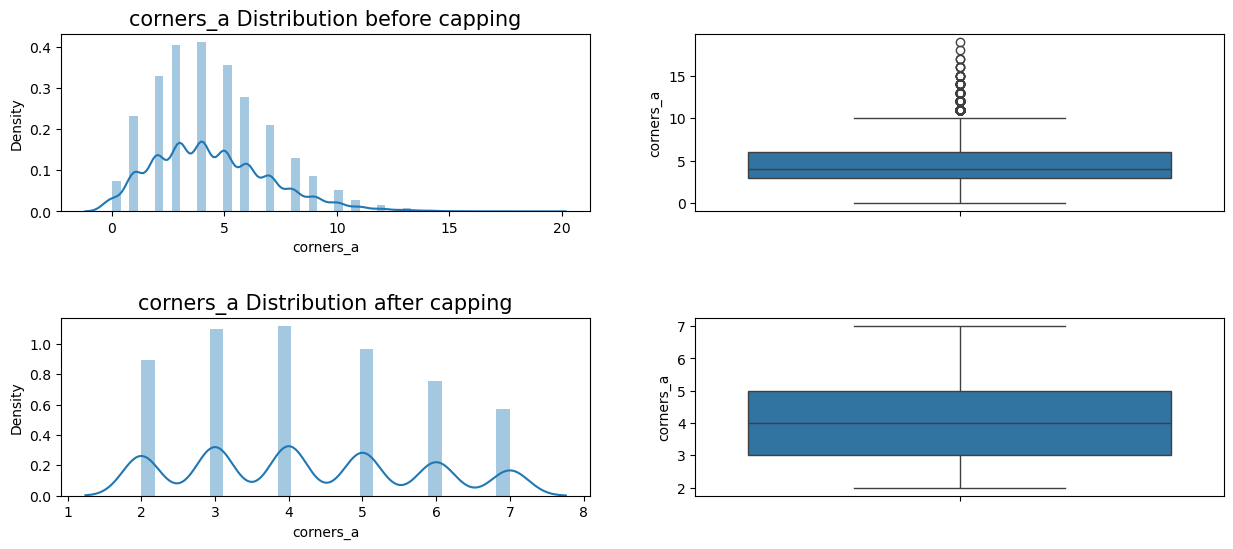

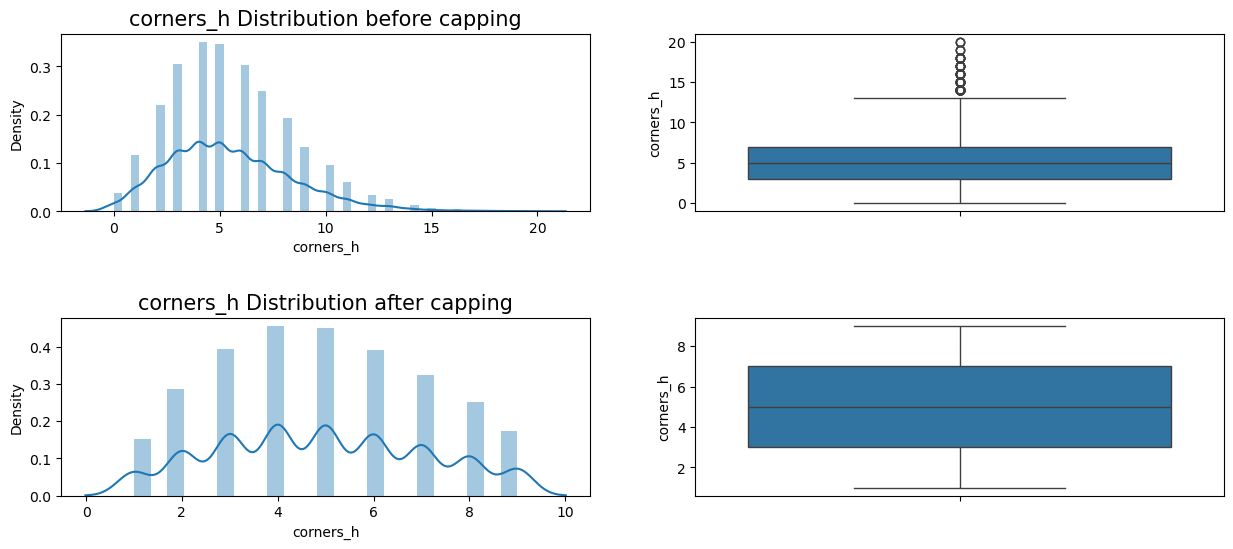

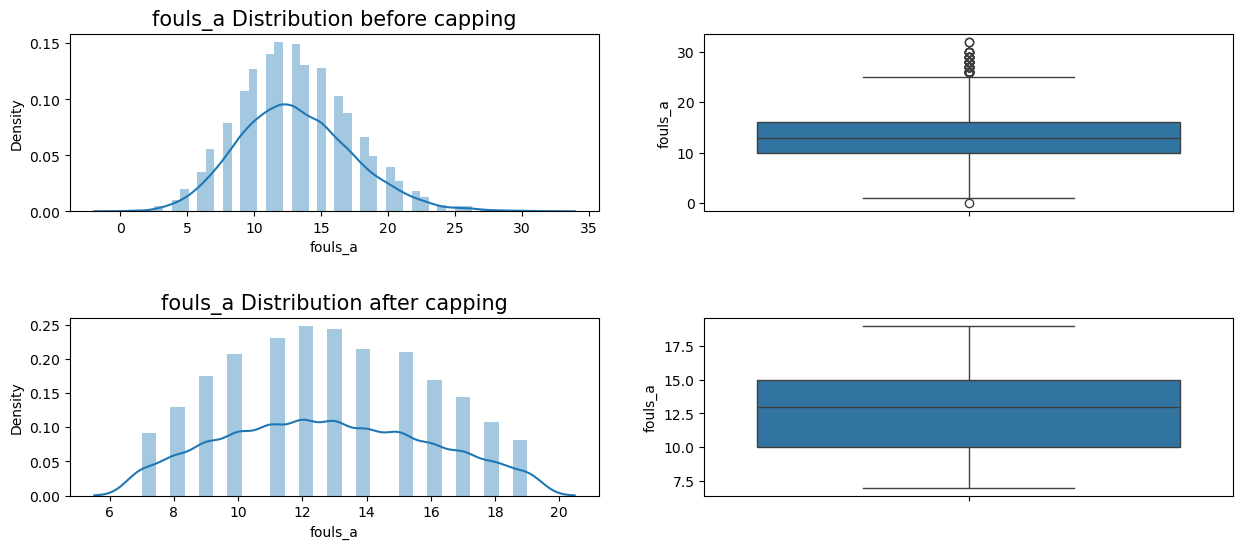

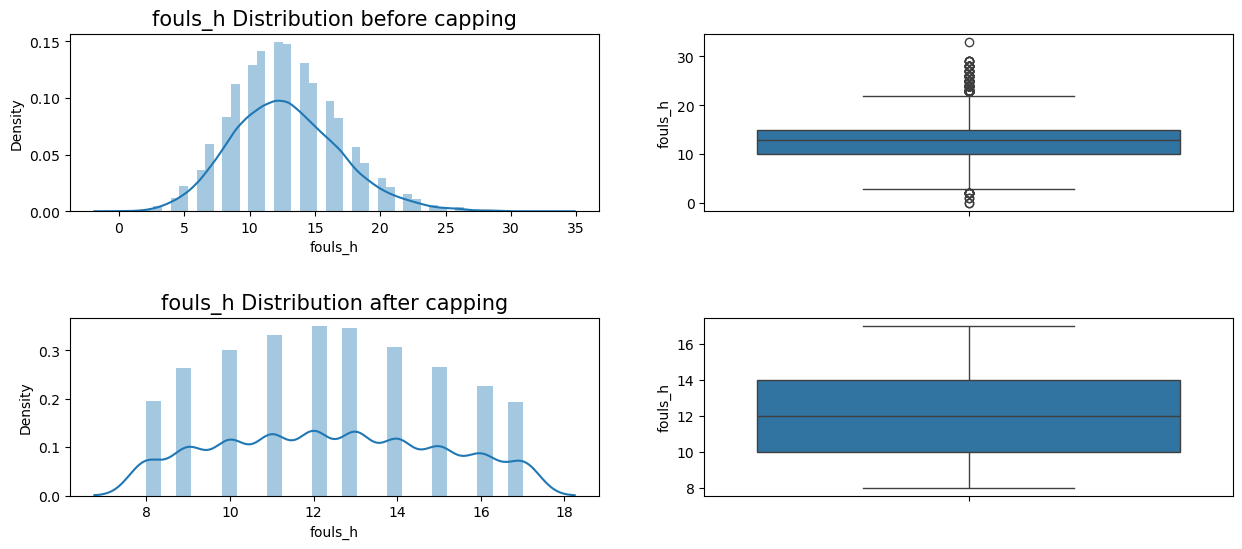

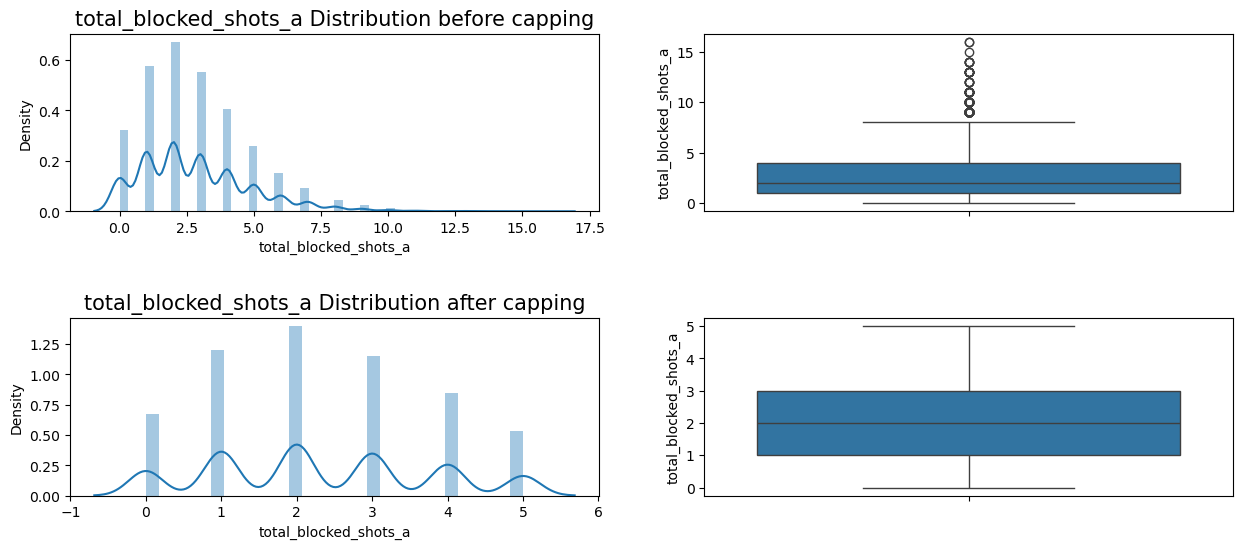

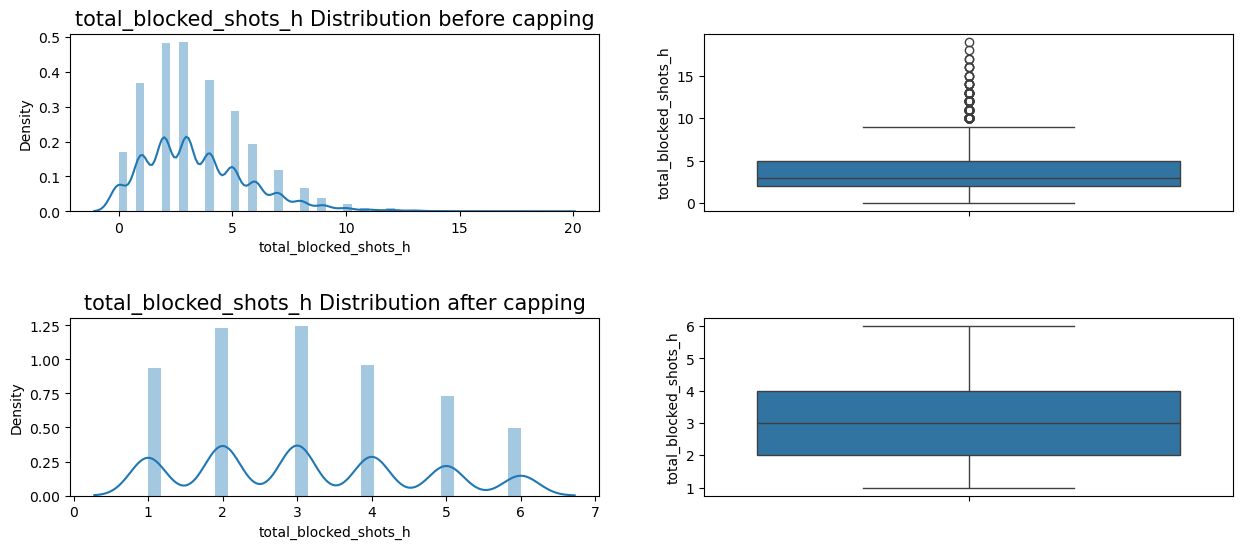

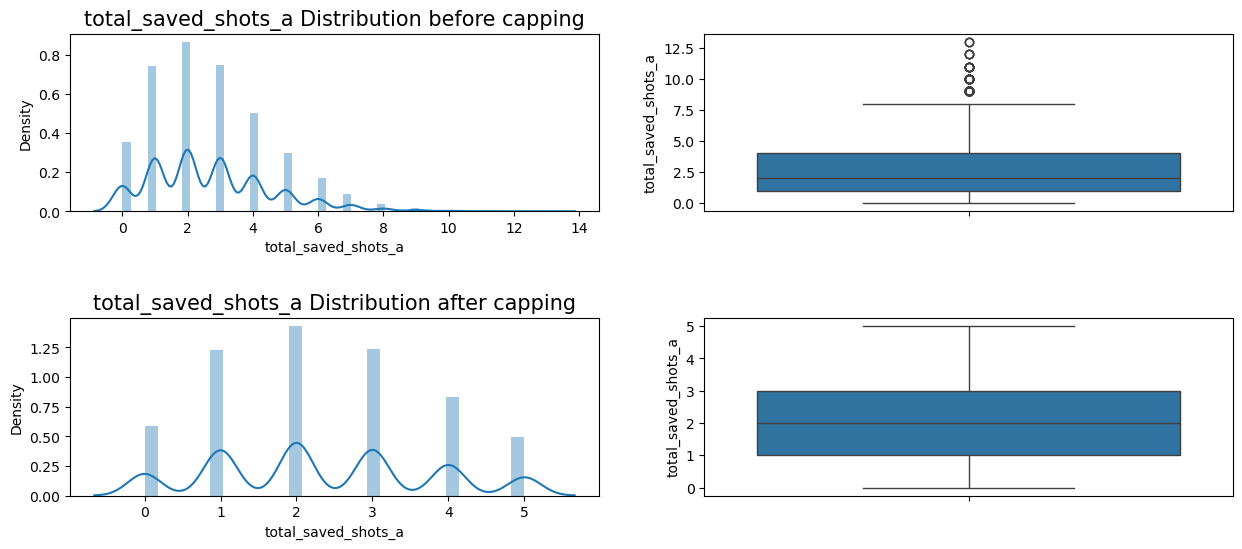

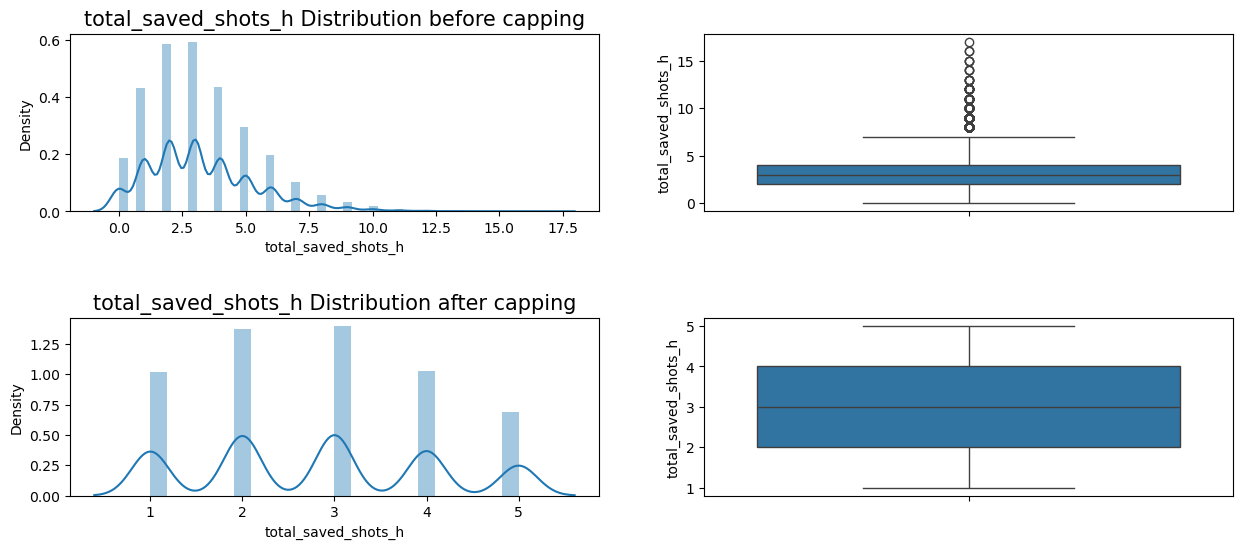

In [130]:
def dist_compare_after_capping(original_df, new, cols):
    for col in relevant_columns_features:
        if col in cols:
            plt.figure(figsize=(15,6))
            plt.subplot(2,2,1)
            sns.distplot(original_df[col])
            plt.title('{} Distribution before capping'.format(col), fontsize=15)
            plt.subplot(2,2,2)
            sns.boxplot(original_df[col])
            plt.subplots_adjust(hspace = 0.6)
            plt.subplot(2,2,3)
            sns.distplot(new[col])
            plt.title('{} Distribution after capping'.format(col), fontsize=15)
            plt.subplot(2,2,4)
            sns.boxplot(new[col])
            plt.show()
dist_compare_after_capping(df, temp, outliers_df.index)

#### After cchecking the result we will drop 8 fetuers 

In [132]:
#relevant_columns=out_df.loc[out_df['drop']=='yes']['feature']
remove_outliers=relevant_columns_features
manipulated_data= df.copy()
for j in range(len(df)):
    for col in remove_outliers:
        if df_outliers.loc[j,col] == 1:
            manipulated_data.loc[j,col] = 0

In [136]:
manipulated_data.to_csv(path_result+'/'+'manipulated_data_no_outleirs.csv')

# Nulls matrix

In [137]:
manipulated_data.head()

,gameID,leagueID,season,date,homeTeamID,awayTeamID,homeGoals,awayGoals,homeGoalsHalfTime,awayGoalsHalfTime,xGoals_h,shots_h,shotsOnTarget_h,deep_h,ppda_h,fouls_h,corners_h,yellowCards_h,redCards_h,teamgoals_h,ownGoals_h,total_assists_h,total_xAssists_h,total_key_passes_h,total_xGoalsChain_h,total_xGoalsBuildup_h,total_blocked_shots_h,total_saved_shots_h,xGoals_a,shots_a,shotsOnTarget_a,deep_a,ppda_a,fouls_a,corners_a,yellowCards_a,redCards_a,teamgoals_a,ownGoals_a,total_assists_a,total_xAssists_a,total_key_passes_a,total_xGoalsChain_a,total_xGoalsBuildup_a,total_blocked_shots_a,total_saved_shots_a,result_h,game_year,game_month,game_day,result
0,81,1,2015,8/8/2015 15:45,89,82,1,0,1,0,0.627539,9,1,4,13.8261,12,1,2.0,0,0,0,0,0.284979,5,1.396328,0.994160,4.0,1.0,0.674600,9,4,10,8.2188,12,2,3,0,0,1,0,0.586365,7,1.745371,0.811549,3.0,4.0,W,2015,8,8,2
1,82,1,2015,8/8/2015 18:00,73,71,0,1,0,0,0.876106,11,2,11,6.9000,13,6,3.0,0,0,0,0,0.419975,9,2.159510,1.170894,2.0,2.0,0.782253,7,3,2,11.8462,13,3,4,0,1,0,1,0.560695,4,1.238205,0.736815,2.0,2.0,L,2015,8,8,0
2,83,1,2015,8/8/2015 18:00,72,90,2,2,0,1,0.604226,10,5,5,6.6500,0,8,1.0,0,2,0,2,0.549139,8,1.025550,0.493522,2.0,3.0,0.557892,11,5,4,17.1579,13,2,2,0,2,0,1,0.418385,8,1.959323,1.030588,3.0,3.0,D,2015,8,8,1
3,84,1,2015,8/8/2015 18:00,75,77,4,2,3,0,2.568030,19,8,5,10.8800,13,6,2.0,0,4,0,2,1.727543,18,6.815649,3.741916,4.0,4.0,1.459460,11,5,6,9.5556,17,3,4,0,2,0,2,1.288886,9,7.622863,5.617276,2.0,3.0,W,2015,8,8,2
4,85,1,2015,8/8/2015 18:00,79,78,1,3,0,1,1.130760,17,6,5,5.7368,14,1,1.0,0,1,0,1,0.416638,12,1.966623,0.699249,3.0,4.0,2.109750,11,7,10,10.6250,0,4,0,0,3,0,3,2.050685,10,10.799517,8.554974,2.0,4.0,L,2015,8,8,0


In [138]:
#Getting a new/updated missing dataset from 'manipulated data' - this time we will call it df_nulls
df_nulls = manipulated_data.copy()
for col in df_nulls:
    if df_nulls[col].isna().sum() == 0:
        del df_nulls[col]

df_nulls

,yellowCards_h,total_blocked_shots_h,total_saved_shots_h,total_blocked_shots_a,total_saved_shots_a
0,2.0,4.0,1.0,3.0,4.0
1,3.0,2.0,2.0,2.0,2.0
2,1.0,2.0,3.0,3.0,3.0
3,2.0,4.0,4.0,2.0,3.0
4,1.0,3.0,4.0,2.0,4.0
...,...,...,...,...,...
12675,2.0,6.0,4.0,1.0,3.0
12676,1.0,3.0,2.0,4.0,3.0
12677,1.0,2.0,4.0,0.0,2.0
12678,1.0,5.0,5.0,1.0,1.0


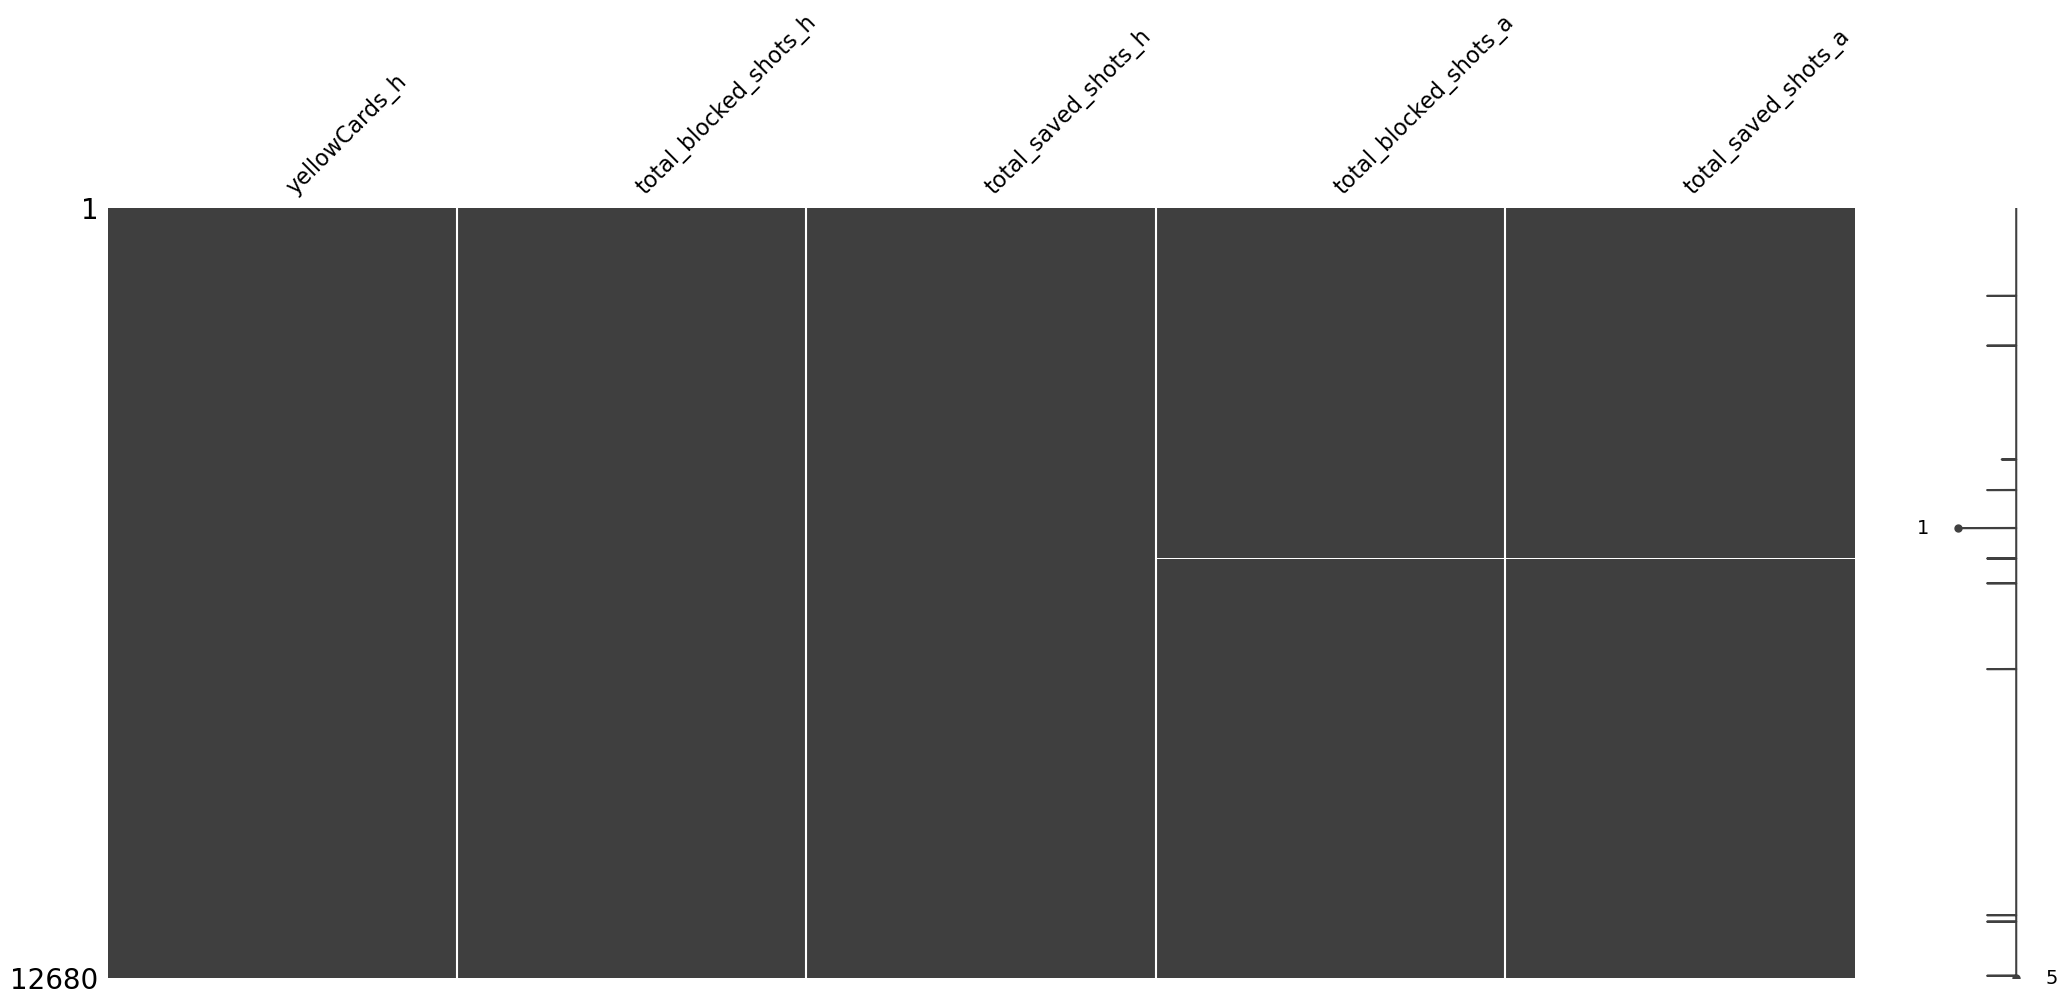

In [141]:
%pip install missingno
import missingno as msno
msno.matrix(df_nulls)
plt.show()

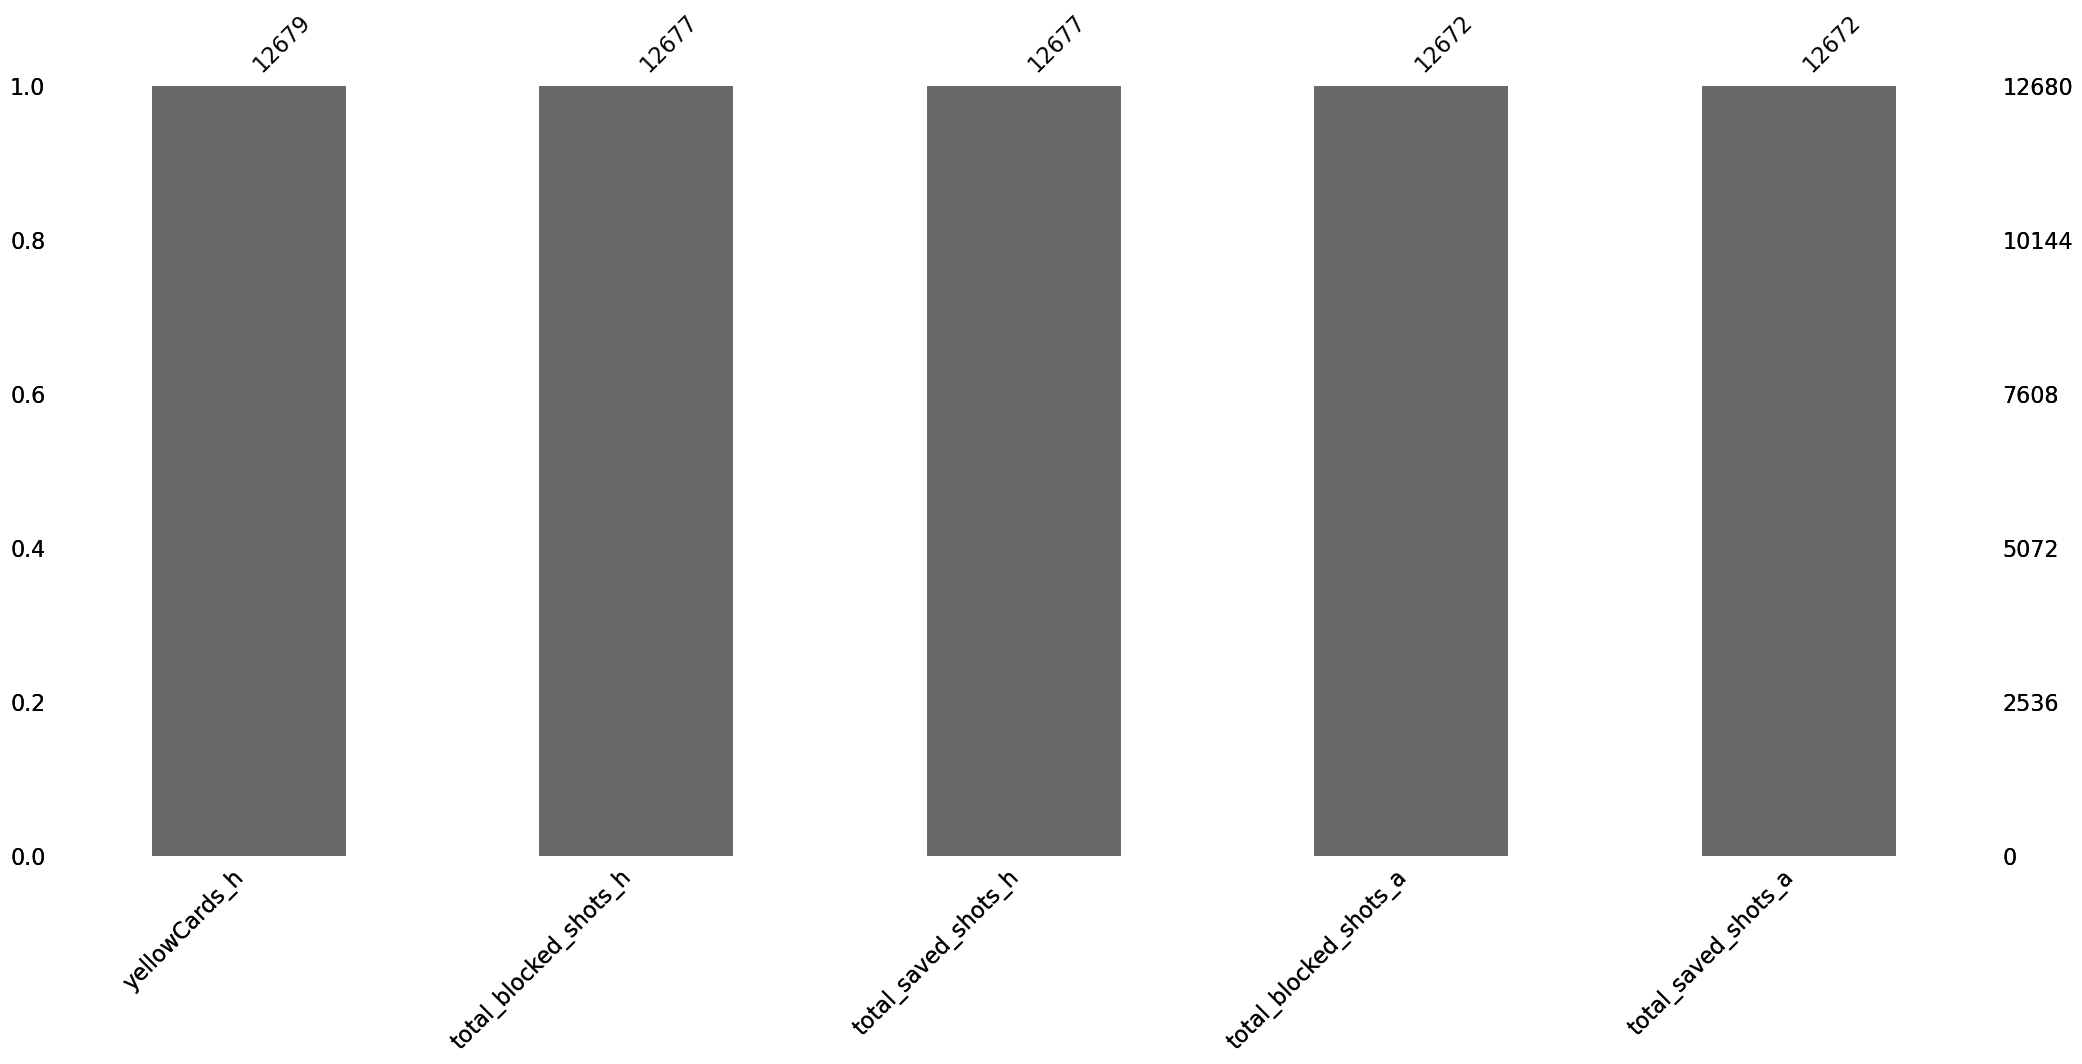

In [143]:
msno.bar(df_nulls)
plt.show()

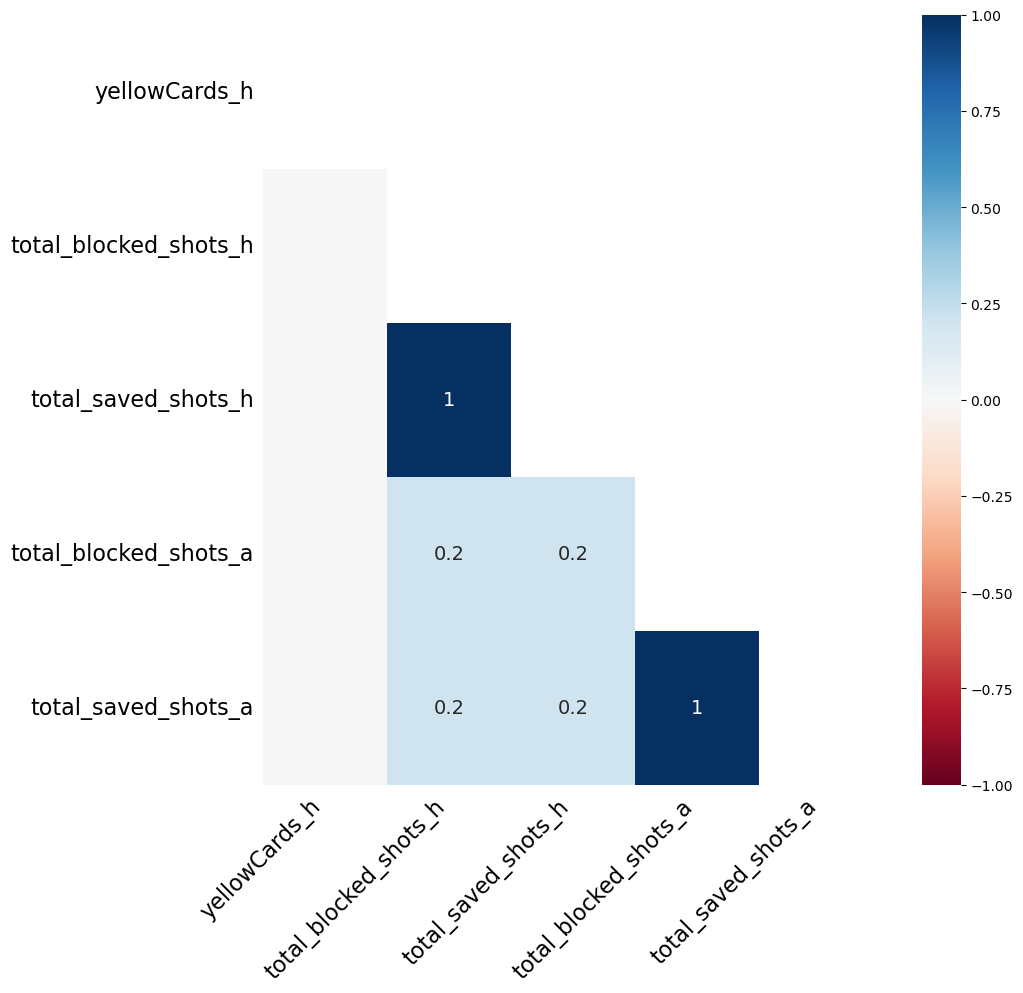

In [145]:
## missingness correlation heatmap
msno.heatmap(df_nulls,figsize=(10,10))
plt.show()

#### Dataframe containing missing value counts and their frequency:

In [144]:
mis_val = df_nulls.isna().sum()
mis_val_per = df_nulls.isna().sum()/len(df_nulls)*100
mis_val_table = pd.concat([mis_val, mis_val_per], axis=1)
mis_val_table_ren_columns = mis_val_table.rename(columns = {0 : 'Missing Values', 1 : '% of Total Values'})
mis_val_table_ren_columns = mis_val_table_ren_columns[mis_val_table_ren_columns.iloc[:,:] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)
mis_val_table_ren_columns

,Missing Values,% of Total Values
total_blocked_shots_a,8,0.1
total_saved_shots_a,8,0.1
total_blocked_shots_h,3,0.0
total_saved_shots_h,3,0.0
yellowCards_h,1,0.0


In [146]:
mis_val_table_ren_columns.sum()

Missing Values       23.0
% of Total Values     0.2
dtype: float64

##### Creating a dataframe with missing values as 1 and existing values as 0:

In [147]:
df_missing_data = manipulated_data.isin([np.nan]) 
df_missing_data = df_missing_data.astype('int')
df_missing_data

,gameID,leagueID,season,date,homeTeamID,awayTeamID,homeGoals,awayGoals,homeGoalsHalfTime,awayGoalsHalfTime,xGoals_h,shots_h,shotsOnTarget_h,deep_h,ppda_h,fouls_h,corners_h,yellowCards_h,redCards_h,teamgoals_h,ownGoals_h,total_assists_h,total_xAssists_h,total_key_passes_h,total_xGoalsChain_h,total_xGoalsBuildup_h,total_blocked_shots_h,total_saved_shots_h,xGoals_a,shots_a,shotsOnTarget_a,deep_a,ppda_a,fouls_a,corners_a,yellowCards_a,redCards_a,teamgoals_a,ownGoals_a,total_assists_a,total_xAssists_a,total_key_passes_a,total_xGoalsChain_a,total_xGoalsBuildup_a,total_blocked_shots_a,total_saved_shots_a,result_h,game_year,game_month,game_day,result
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12675,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12676,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12677,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12678,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


##### Creating df including numeric features of the later data - manipulated_data

##### Difference in the distribution of a variable when another variable is with or without MV:

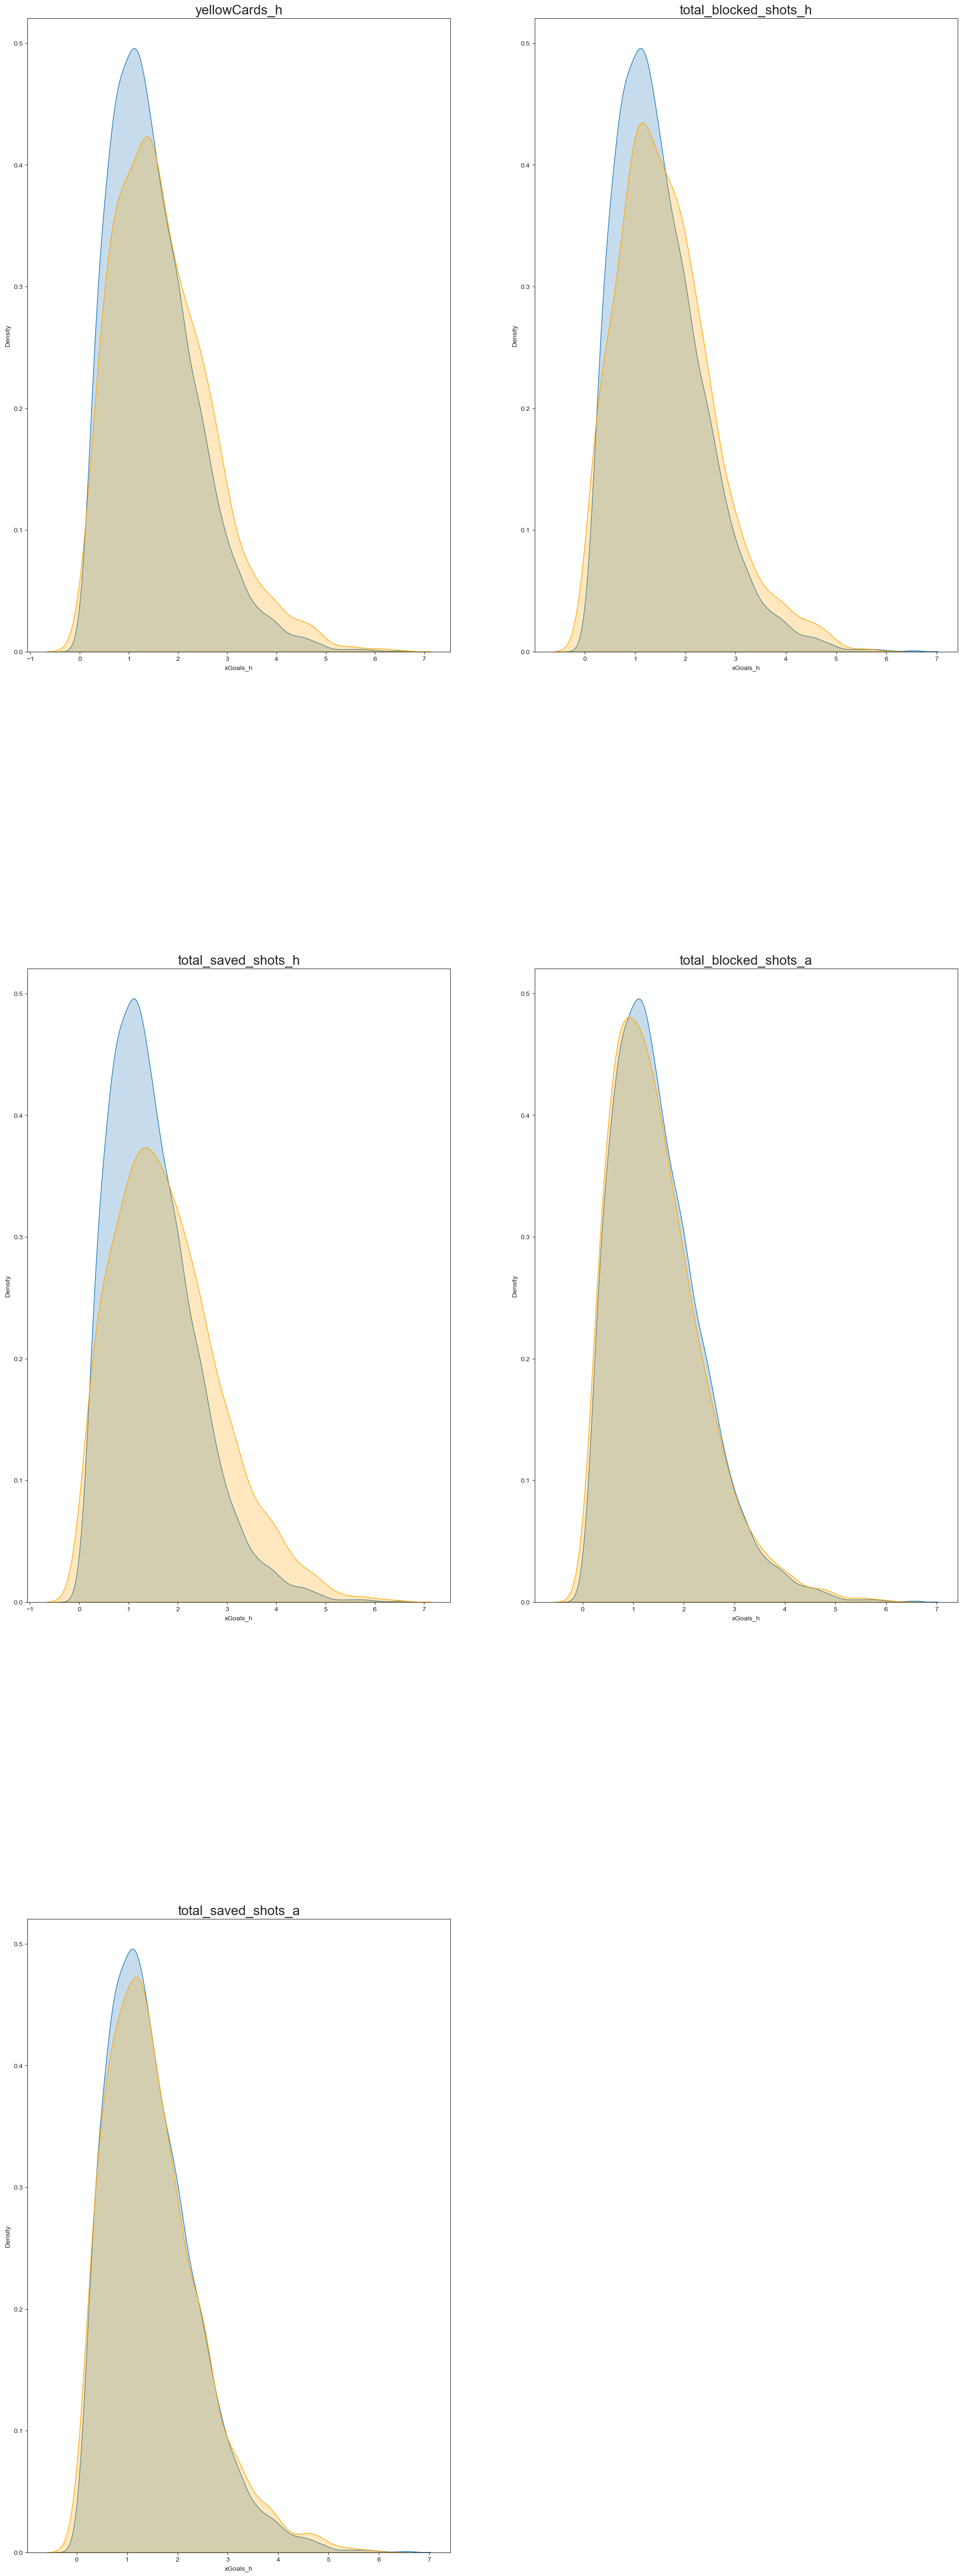

In [148]:
#c = numeric_manipulated_data.columns
colist = df_nulls.columns
#names = missing_names
#sns.set(font_scale = 0.8)
#sns.set_style("whitegrid")
sns.set_style("ticks")
sns.set
a=len(colist)
b=2
c=1
fig = plt.figure(figsize=(25,120))
plt.subplots_adjust(hspace=0.5)
for j in df_nulls:
        if j!=i :
            plt.subplot(a,b,c)
            plt.title('{}'.format(j),fontsize=20)
            plt.xlabel(i)
            sns.kdeplot(df[i],fill=True)
            sns.kdeplot(df[i].loc[df_nulls[j]==0],fill=True,color='orange')
        c=c+1
        
plt.show()

In [162]:
df_num = pd.Index(df_num.tolist() + ['result']).unique()

##### Exploring data the segnificunce of distribution change:

In [167]:
#le = preprocessing.LabelEncoder()
MV_df_final = pd.DataFrame(columns= ['Var', 'MV_pct', 'distribution_changed'])
#df[m] = le.fit_transform(df[m].astype(str))
m=df[df_num].copy()
#m = manipulated_data._get_numeric_data().columns.dropna().unique()
np.seterr(divide='ignore', invalid='ignore')
for i in m: 
    # and i in mis_val_table_ren_columns.index.tolist():
    # column with NULLS
        null = m[i]
    # column without NULLS
        non = m[i].loc[df_missing_data[i]==0]
    # target value with NULLS
        result_null = m['result']
    # target value without NULLS
        result_non = result_null.loc[df_missing_data[i]==0]
        mv = df_missing_data[i].sum()
    # perform Kolmogorov-Smirnov test
        pval = ks_2samp(null, non)[1]
        dis_change = np.where(pval<0.5,'+','-')
        MV_df_final = pd.concat([MV_df_final, pd.DataFrame([{
            'Var': i,
            'MV_pct': mv,
            'distribution_changed': dis_change
        }])], ignore_index=True)
MV_df_final

,Var,MV_pct,distribution_changed
0,corners_a,0,-
1,corners_h,0,-
2,deep_a,0,-
3,deep_h,0,-
4,fouls_a,0,-
5,fouls_h,0,-
6,ppda_a,0,-
7,ppda_h,0,-
8,shotsOnTarget_a,0,-
9,shotsOnTarget_h,0,-


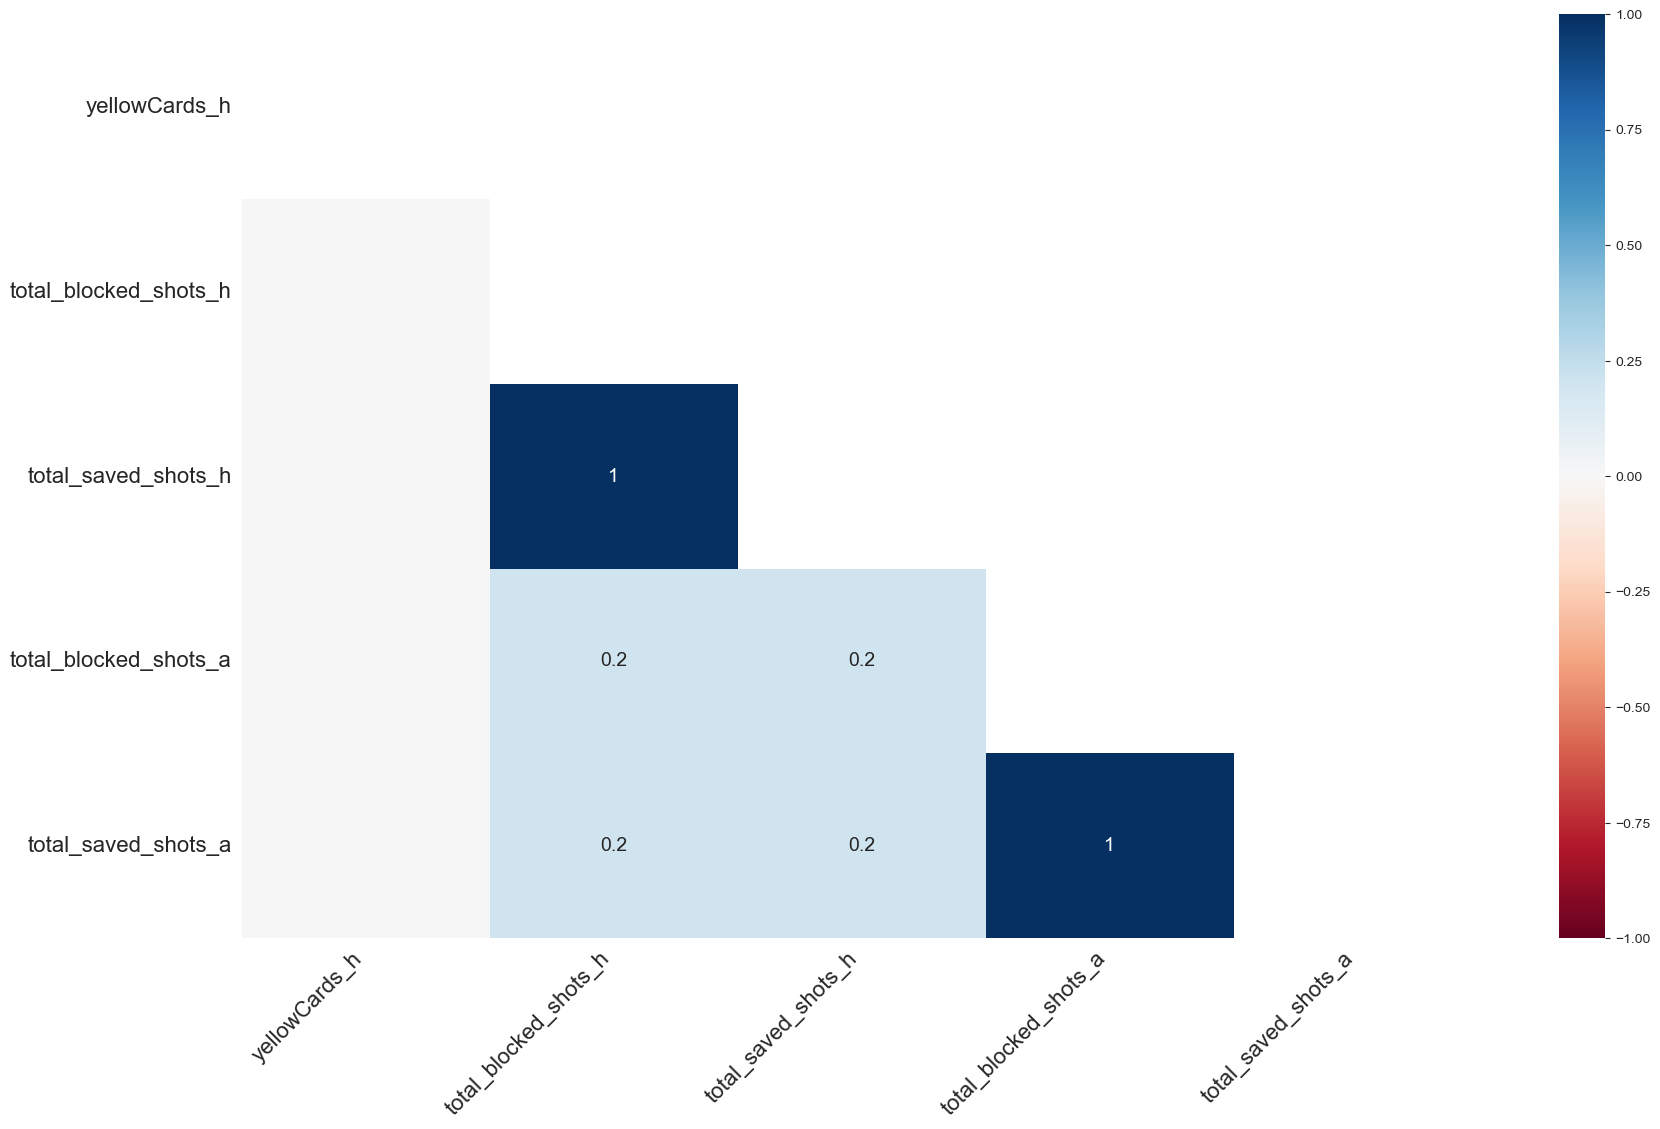

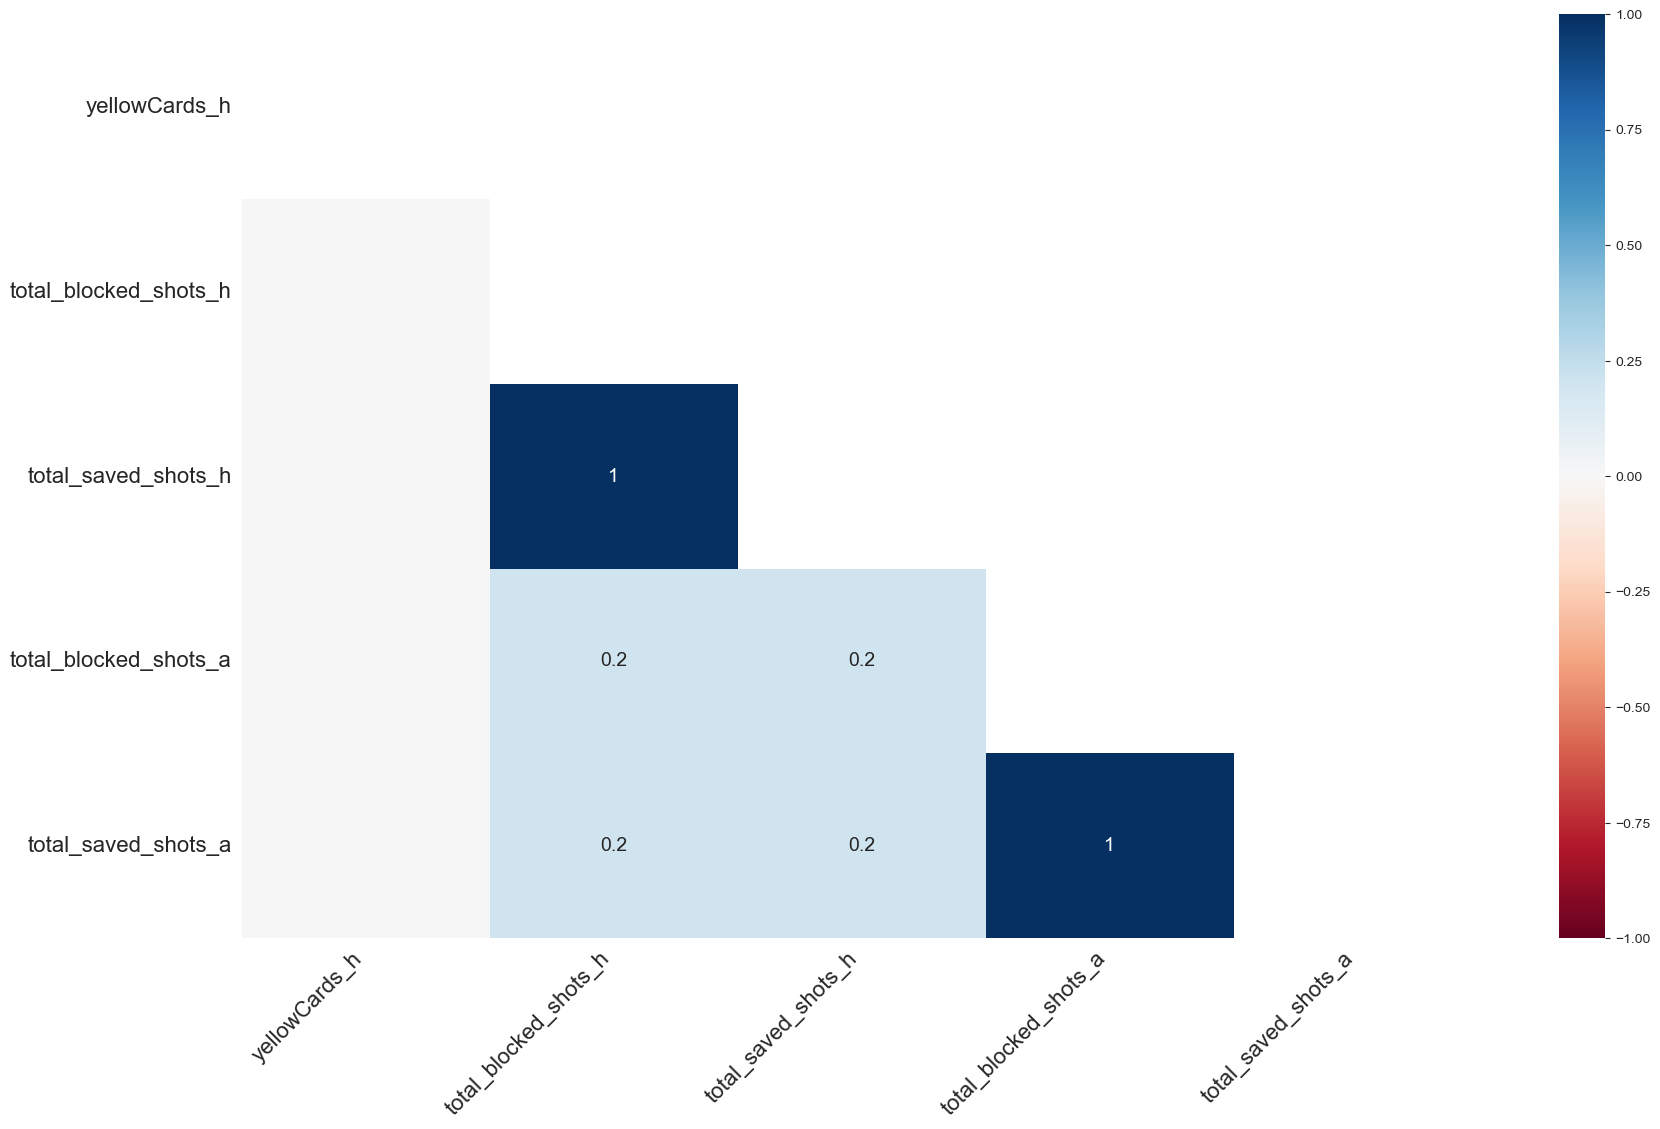

In [170]:
msno.heatmap(manipulated_data)
plt.show()

In [171]:
MV_df_final['drop']= 'Yes'
MV_df_final['MV_type']= 'MCAR/MAR'
MV_df_final.loc[(MV_df_final.distribution_changed== '+'),'drop']='No'
MV_df_final.loc[(MV_df_final.distribution_changed== '+'),'MV_type']='MNAR'
MV_df_final = MV_df_final[MV_df_final['MV_pct']>0].sort_values(by='MV_pct', ascending=False)
MV_df_final

,Var,MV_pct,distribution_changed,drop,MV_type
12,total_blocked_shots_a,8,-,Yes,MCAR/MAR
16,total_saved_shots_a,8,-,Yes,MCAR/MAR
13,total_blocked_shots_h,3,-,Yes,MCAR/MAR
17,total_saved_shots_h,3,-,Yes,MCAR/MAR


### KNN

In [196]:
# add random of missing data
def introduce_nan(df, columns, fraction=0.05, random_state=None):
    """
    Introduce NaN values in random locations in specified columns.

    Parameters:
    df (pd.DataFrame): The input DataFrame.
    columns (list): List of column names to introduce NaN values.
    fraction (float): The fraction of values to replace with NaN (default: 0.1).
    random_state (int): Seed for reproducibility (optional).

    Returns:
    pd.DataFrame: DataFrame with NaN values introduced.
    """
    df_copy = df.copy()
    np.random.seed(random_state)
    
    for col in columns:
        num_nan = int(len(df) * fraction)  # Number of NaNs to introduce
        nan_indices = np.random.choice(df.index, num_nan, replace=False)
        df_copy.loc[nan_indices, col] = np.nan
    
    return df_copy
#df = introduce_nan(df_work, columns=['xGoals_h', 'xGoals_a','deep_h','deep_a'], fraction=0.05, random_state=42)

In [197]:
df_test_na=manipulated_data.copy()
df_test_na = introduce_nan(df_test_na, columns=['xGoals_h', 'xGoals_a','deep_h','deep_a'], fraction=0.05, random_state=42)

In [172]:
manipulated_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12680 entries, 0 to 12679
Data columns (total 51 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   gameID                 12680 non-null  int64   
 1   leagueID               12680 non-null  category
 2   season                 12680 non-null  category
 3   date                   12680 non-null  object  
 4   homeTeamID             12680 non-null  int64   
 5   awayTeamID             12680 non-null  int64   
 6   homeGoals              12680 non-null  category
 7   awayGoals              12680 non-null  category
 8   homeGoalsHalfTime      12680 non-null  category
 9   awayGoalsHalfTime      12680 non-null  category
 10  xGoals_h               12680 non-null  float64 
 11  shots_h                12680 non-null  int64   
 12  shotsOnTarget_h        12680 non-null  int64   
 13  deep_h                 12680 non-null  int64   
 14  ppda_h                 12680 non-null 

In [188]:
df_football=manipulated_data.copy()
df_football=df_football.drop(columns='result_h')
from sklearn.impute import KNNImputer

imp_cols = df_football.select_dtypes(include = ['float64', 'int64','category']).columns
knn_imputer = KNNImputer(n_neighbors=1)
imputed_data = pd.DataFrame(knn_imputer.fit_transform(df_football[imp_cols]),columns = imp_cols)
df_football[imp_cols] = imputed_data
df_football.isnull().sum().sum()

In [191]:
df_football.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12680 entries, 0 to 12679
Data columns (total 50 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   gameID                 12680 non-null  float64
 1   leagueID               12680 non-null  float64
 2   season                 12680 non-null  float64
 3   date                   12680 non-null  object 
 4   homeTeamID             12680 non-null  float64
 5   awayTeamID             12680 non-null  float64
 6   homeGoals              12680 non-null  float64
 7   awayGoals              12680 non-null  float64
 8   homeGoalsHalfTime      12680 non-null  float64
 9   awayGoalsHalfTime      12680 non-null  float64
 10  xGoals_h               12680 non-null  float64
 11  shots_h                12680 non-null  float64
 12  shotsOnTarget_h        12680 non-null  float64
 13  deep_h                 12680 non-null  float64
 14  ppda_h                 12680 non-null  float64
 15  fo

0

In [194]:
df_football.to_csv(path_result+'/'+'after_missing_value_KNN.csv')

In [198]:
# test using nulls reduction 
df_football_test_na=df_test_na.copy()
df_football_test_na=df_football_test_na.drop(columns='result_h')
from sklearn.impute import KNNImputer

imp_cols = df_football_test_na.select_dtypes(include = ['float64', 'int64','category']).columns
knn_imputer = KNNImputer(n_neighbors=1)
imputed_data = pd.DataFrame(knn_imputer.fit_transform(df_football_test_na[imp_cols]),columns = imp_cols)
df_football_test_na[imp_cols] = imputed_data
df_football_test_na.isnull().sum().sum()

0

In [199]:
df_football_test_na.to_csv(path_result+'/'+'after_missing_value_KNN_test_na.csv')